# Reading the FTP files from Rescue Groups API

In [ ]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

def getAge(birthdate,timestamp):
  
  if not isinstance(birthdate, datetime.date):
    cleanbirthdate = birthdate.replace('\\','')
    finalbirthdate = datetime.datetime.strptime(cleanbirthdate,'%m/%d/%Y')
  else:
    finalbirthdate = birthdate

  cleantimestamp = datetime.datetime.utcfromtimestamp(timestamp).strftime('%m/%d/%Y')
  finaltimestamp = datetime.datetime.strptime(cleantimestamp,'%m/%d/%Y')

  diff = relativedelta(finaltimestamp,finalbirthdate)
  if diff.months > 6:
    age = diff.years +1
  else:
    age = diff.years

  if age < 0 or age > 20:
    age = None

  return age

def getRows(json):
  if len(json['pictures']) != 0:
    df = pd.json_normalize(json, record_path= ['pictures'], meta = ['name','animalLocation','sex','animalID','descriptionPlain','mediaLastUpdated','primaryBreed','secondaryBreed', 'mixed', 'age','birthdate', 'size'])
    df = df.drop(['largeUrl','smallUrl','fullsizeUrl','thumbnailUrl', 'mediaID','mediaOrder','original.fileSize','original.url','large.fileSize','large.resolutionX','large.resolutionY','large.url','small.fileSize','small.resolutionX','small.resolutionY','small.url'], axis =1)
    return df
  else:
    df = pd.DataFrame()
    return df

def addAgestoDf(df):
  df['exact_age'] = ''
  df['clean_url'] = ''
  for i in range(len(df['birthdate'])):
    df['clean_url'][i] = df['originalUrl'][i].replace('\\','')
    if df['birthdate'][i] != '':
      df['exact_age'][i] = getAge(df['birthdate'][i],int(df['mediaLastUpdated'][i]))
  return df

def getDfFromlistofJSON(jsonfilepath):
  alldata = open(jsonfilepath,'r')
  animallist = [eval(animal.rstrip('\n')) for animal in alldata]

  dflist = []
  for animal in animallist:
    df = getRows(animal)
    if not df.empty:
      dflist.append(df)  
  finaldf = pd.concat(dflist)
  finaldf = finaldf.reset_index(drop=True)
  finaldfwage = addAgestoDf(finaldf)

  finaldfwage['source'] = ''
  finaldfwage = finaldfwage.assign(source = 'Rescue Groups')

  return finaldfwage


In [ ]:
# don't have the file already? make it here
pet1df = getDfFromlistofJSON('/Dx0pNB2T_pets_1.json')
pet2df = getDfFromlistofJSON('/Dx0pNB2T_pets_2.json')
pet3df = getDfFromlistofJSON('/Dx0pNB2T_pets_3.json')

resgroup = pd.concat([pet1df,pet2df,pet3df],ignore_index = True)

resgroup['source'] = ''
resgroup = resgroup.assign(source = 'Rescue Groups')

In [ ]:
#csv makes things strings so i'm switching it back
print(len(resgroup))
resgroup['original.resolutionX'] = pd.to_numeric(resgroup['original.resolutionX'])
resgroup['original.resolutionY'] = pd.to_numeric(resgroup['original.resolutionY'])

83191


In [ ]:
#getting rid of photos that are too small - is this necessary? probably wouldn't have done this in the future
filterdf = resgroup[resgroup['original.resolutionX']>375]
filterdf = filterdf[filterdf['original.resolutionY']>375]
filterdf= filterdf.reset_index(drop=True)
print(len(filterdf))

74536


# Extracting Age from Description

In [ ]:
#some date/age testing
from dateutil import parser
import re

# some entry descriptions have an estimated birthdate, so imma just add that date to my column so it now had an exact age
# dateutil is p nice - it parses an age from the string so you don't have to use messy regex stuff
for i in range(len(filterdf['descriptionPlain'])):
  entry = filterdf['descriptionPlain'][i]
  if 'Estimated Birthdate:' in entry:
    indexofpart = entry.find('Estimated Birthdate:')
    agestring = entry[indexofpart:indexofpart+33]
    print(agestring)
    res = parser.parse(agestring, fuzzy = True)
    filterdf.at[i,'birthdate'] = res

In [ ]:
# some entry descriptions have an estimated birthdate, so imma just add that date to my column so it now had an exact age

for i in range(len(filterdf['descriptionPlain'])):
  entry = filterdf['descriptionPlain'][i]
  if type(entry) != float:
    if 'Birthdate:' in entry:
      indexofpart = entry.find('Birthdate:')
      agestring = entry[indexofpart:indexofpart+24]

      try:
        res = parser.parse(agestring, fuzzy = True)
        print('Known: {0}, Calculated: {1}'.format(type(filterdf['birthdate'][i]),res))

        if type(filterdf['birthdate'][i]) == str:
          filterdf.at[i,'birthdate'] = res

        print('Known: {0}, Calculated: {1}'.format(filterdf['birthdate'][i],res))
      except:
        print('no date found')

In [ ]:
# some entry descriptions have an estimated birthdate, so imma just add that date to my column so it now had an exact age

count = 0
countt = 0
for i in range(len(filterdf['descriptionPlain'])):
  months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
  entry = filterdf['descriptionPlain'][i]
  if type(entry) != float and filterdf['birthdate'][i] == '':
    if 'DOB' in entry:
      indexofpart = entry.find('DOB')
      cutentry = entry[indexofpart:indexofpart+40]
      cutentry = cutentry.replace(')',"").replace('(',"").replace(' - ',"").replace('\\',"")

      if 'tbd' not in cutentry:
        if 'Weight' in cutentry or 'weight' in cutentry:
          agestring = cutentry[:20]
        elif any(map(cutentry.__contains__, months)):
          agestring = cutentry
        elif 'approx' in cutentry:
          agestring = cutentry[:19]
        elif 'app' in cutentry or 'App' in cutentry:
          agestring = cutentry
        else:
          agestring = cutentry[:16]
      
      try:
        res = parser.parse(agestring, fuzzy = True)
        today =  datetime.now()
        if res.date() > today.date():
          count +=1
          print('this date is wrong')
        else:
          filterdf.at[i,'birthdate'] = res
          print("{0}:  calculated: {1}".format(agestring,res))
      except:
        countt += 1
        #print("NO DATE FOUND: {0}".format(agestring))
        print('error')

print(str(count) + ',' + str(countt))

In [ ]:
# this section uses the spacy nlp and regular expression to get the age out of a string. works fairly well, but def not as wel as a custom nlp would
import spacy
from spacy.matcher import Matcher
import regex as re
possible_weight_words = ["pounds", "pound", "lbs", "lb", "oz"]
numdict = {'one':1,
             'two':2,
             'three':3,
             'four':4,
             'five':5,
             'six':6,
             'seven':7,
             'eight':8,
             'nine':9,
             'ten':10,
             'eleven':11}

sp_lg = spacy.load('en_core_web_sm')

def getting_age_from_desc(desc):
  label_list = []
  for ent in sp_lg(desc).ents:
    label_list.append(ent.label_)
  if 'DATE' in label_list:
    for ent in sp_lg(desc).ents:
      if ent.label_ == 'DATE':
        return ent.text.strip()
  elif "CARDINAL" in label_list:
    for ent in sp_lg(desc).ents:
      if ent.label_ == 'CARDINAL':
        return ent.text.strip()
             
def removechar(rawdesc,index):
  if rawdesc[index].isdigit():
    rawdesc = rawdesc[0:index:]+rawdesc[index+1::]
    return rawdesc
  else:
    return rawdesc


def removeNearbyNumbers(description,startindex):
  
  rawtext = description

  for indexint in startindex:
    if indexint != -1:
      for i in range(0,6):
        numindex = indexint-i
        rawtext = removechar(rawtext,numindex)

      for substring in possible_weight_words:
        if substring in rawtext:
          rawtext = rawtext.replace(substring, "")

  return rawtext

def getAgeRegex(description):
  age = re.findall(r'Age[\:\s](\d{1,2})', description)
  age.extend(re.findall(r' (\d{1,2}),? ', description))
  if len(age) == 0:
    age = re.findall(r'\((\d{1,2})\)', description)
  if len(age) == 0:
    age = re.findall(r'(\d+).*?(?i)(yrs)', description)
  if len(age) == 0:
    age = re.findall(r'(\d+)(?i)yr', description)
  if len(age) == 0:
    age = re.findall(r'[0-9]+-(year).*', description)
  #print(description+ " --- AGE: "+ str(set(age)))
  return getting_age_from_desc(description)

def getNumfromString(string):
  dec = re.compile('^[0-9]*\.[0-9]+$')
  dash = re.compile('\d+(\.\d{1,2})?-\d+(\.\d{1,2})?')

  age = []

  for word in string.split():
    if word.isdigit() or dec.match(word):
       age.append(float(word))
    elif dash.match(word):
      for character in word:
        if character.isdigit():
          age.append(float(character))

  if len(age) == 0:
    age = [float(numdict[numword]) for numword in string.split() if numword in [*numdict]]
  return age

def getAgefromString(string):
  numdict = {'one':1,
             'two':2,
             'three':3,
             'four':4,
             'five':5,
             'six':6,
             'seven':7,
             'eight':8,
             'nine':9,
             'ten':10,
             'eleven':11}
  possible_week = ["wk","week","Wk","Week"]
  possible_months = ["month","mnth","mth","Month","Mnth","Mth"]
  possible_yrs= ["yr","years","Yr","Years"]

  string = str(string)
  if string != "None":
    if any(map(string.__contains__, possible_yrs)):

      age = getNumfromString(string)
      return age

    if any(map(string.__contains__, possible_week)):

      age = [num/52 for num in getNumfromString(string)]
      return age 
    
    if any(map(string.__contains__, possible_months)):

      age = [num/12 for num in getNumfromString(string)] 
      return age
    else:
      age = getNumfromString(string)
      return age
  else:
    return None

def avg(lst):
  print(type(lst))
  return sum(lst)/len(lst)

In [ ]:
# some entires have a "age as of ___" in their description so im getting the birthdate form that and adding to the df
count = 0
for i in range(len(filterdf['descriptionPlain'])):
  entry = filterdf['descriptionPlain'][i]
  if 'Best Guess for Age' in entry:

    count +=1
    indexofpart = entry.find('Best Guess for Age')
    agestring = entry[indexofpart:indexofpart+55]
    indexofagestart = int(agestring.find(':'))+2
    indexofageend = int(agestring.find(' as of'))

    if indexofagestart != None and indexofageend!= None:
      age = getAgefromString(getAgeRegex(agestring[indexofagestart:indexofageend]))
      datestring = agestring[indexofageend+7:indexofageend+21]
      print(age)
      if age:
        if len(age) >1:
          finalage = avg(age)
        else:
          finalage = age[0]
      
      try:
        res = parser.parse(datestring, fuzzy = True)
        print(res)

      except:
        res = None
      
      if res != None:
       birthdate = res - relativedelta(days = int(finalage*365))
       filterdf.at[i,'birthdate'] = birthdate

# Trying to find Duplicates using Description


In [ ]:
# this was before i realized petfinder gets its data from rescuegroups LMAO so i guess this is uneccessary now....
# getting petfinder data and adding here so data is together
petfinderdf = pd.read_csv('/content/petfindernew.csv', header = 0, index_col = 0)
petfinderdf['source'] = ''
petfinderdf = petfinderdf.assign(source = 'Petfinder')
petfinderdf.head()

In [ ]:
readytomerge = pd.DataFrame()
readytomerge['clean_url'] = petfinderdf['primary_photo_cropped.full']
readytomerge['age'] = petfinderdf['age']
readytomerge['descriptionPlain'] = petfinderdf['description']
readytomerge['secondaryBreed'] = petfinderdf['breeds.secondary']
readytomerge['primaryBreed'] = petfinderdf['breeds.primary']
readytomerge['animalID'] = petfinderdf['id'].astype(float)
readytomerge['mixed'] = petfinderdf['breeds.mixed']
readytomerge['animalLocation'] = petfinderdf['contact.address.postcode']
readytomerge['size'] = petfinderdf['size']
readytomerge['sex'] = petfinderdf['gender']
readytomerge['source'] = petfinderdf['source']

In [ ]:
togetherdf =  alldata.merge(readytomerge,how="outer")
togetherdf

In [ ]:
togetherdf['possibleDupe'] = togetherdf.duplicated(keep = 'first', subset = ['animalLocation','name','primaryBreed','size','sex'])

In [ ]:
togetherdf['possibleDupe']

In [ ]:
#cleaning our data

togetherdf['cleanDescription'] = ''
for i in range(len(togetherdf['description'])):
  if type(togetherdf['description'][i]) != float:
    if '&amp;#39;' in petfinderdf['description'][i]:
      petfinderdf.loc['cleanDescription'][i] = petfinderdf['description'][i].replace('&#39;',"'")
    if "\n" in petfinderdf['description'][i]:
      petfinderdf.loc['cleanDescription'][i] = petfinderdf['description'][i].replace('\n','')
    if "\\" in petfinderdf['description'][i]:
      petfinderdf.loc[i,'description'] = petfinderdf['description'][i].replace('\\','')
    if "&quot;" in petfinderdf['description'][i]:
      petfinderdf.loc['cleanDescription'][i] = petfinderdf['description'][i].replace('&quot;','"')
    if "&#039;" in petfinderdf['description'][i]:
      petfinderdf.loc['cleanDescription'][i] = petfinderdf['description'][i].replace('&#039;',"'")


&amp;#39; &#039; &amp;#34;(!)
for i in range(len(alldata['descriptionPlain'])):
  if '&#39;' in alldata['descriptionPlain'][i]:
    alldata.loc[i,'descriptionPlain'] = alldata['descriptionPlain'][i].replace('&#39;',"' ")
  if "\n" in alldata['descriptionPlain'][i]:
    alldata.loc[i,'descriptionPlain'] = alldata['descriptionPlain'][i].replace('\n','')
  if "\\" in alldata['descriptionPlain'][i]:
    alldata.loc[i,'descriptionPlain'] = alldata['descriptionPlain'][i].replace('\\','')

In [ ]:
# how many exact dates will we have?
count = 0 
for entry in alldata['birthdate']:
  if not entry == '':
    count +=1
print(count)

50416


In [ ]:
for entry in alldata['isDup']:
  if entry == 'True':
    print('true')

In [ ]:
listofdescraw = petfinderdf['description'].to_list()
listofdes = [desc for desc in listofdescraw if type(desc) != float]

In [ ]:
breeddesc = {breed: [] for breed in columnnames}

In [ ]:
for i in range(len(petfinderdf['description'])):
  if type(petfinderdf['description'][i]) != float:
    breeddesc[petfinderdf['breeds.primary'][i]].append(petfinderdf['description'][i])

# Web Scraping for more Images

In [ ]:
!pip3 install beautifulsoup4

## Animal Humane Society

In [ ]:
import requests
from bs4 import BeautifulSoup

URL = 'https://www.animalhumanesociety.org/adoption/dogs'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')
animaldata = soup.find(class_='view-content content--contained')

In [ ]:
animalentries = animaldata.find_all(class_='views-row')

In [ ]:
dictlist = []
for entry in animalentries:
  keys = ['name','exact_age','primaryBreed','secondaryBreed','mixed','clean_url','source']
  dictforappend = dict.fromkeys(keys)

  breed = entry.find("div", class_ = 'field field--breed')
  breedstring = breed.text.strip()
  endofpbreed = breedstring.find('/')
  firsthalf = breedstring[:endofpbreed]
  startofsbreed = firsthalf.find(',')
  if 'Pit Bull' in breedstring[:endofpbreed]:
    primarybreed = 'Pit Bull Terrier'
  elif 'Retriever, Labrador' in breedstring[:endofpbreed]: 
    primarybreed = 'Labrador Retriever'
  elif 'Chihuahua, Short Coat' in breedstring[:endofpbreed]: 
    primarybreed = 'Chihuahua'
  elif "," in firsthalf:
    raw = firsthalf[startofsbreed+2:] + firsthalf[:startofsbreed]
    primarybreed = " ".join(raw.split())
  else:
    primarybreed = firsthalf
  dictforappend['primaryBreed'] = primarybreed

  secondhalf = breedstring[endofpbreed+2:]

  if 'Mix' in secondhalf:
    dictforappend['mixed'] = 'Yes'
    secondarybreed = ''
  elif 'Retriever, Labrador' in secondhalf: 
    dictforappend['mixed'] = 'No'
    secondarybreed = 'Labrador Retriever'
  elif 'Pit Bull' in secondhalf:
    dictforappend['mixed'] = 'No'
    secondarybreed = 'Pit Bull Terrier'
  else:
    dictforappend['mixed'] = 'No'
    secondarybreed = secondhalf
  
  dictforappend['secondaryBreed'] = secondarybreed
  
  dictforappend['source'] = 'AnimalHumaneSociety'

  agestring = entry.find("div", class_ = 'field field--sex')
  agestring = agestring.text.strip()
  indexofagestart = agestring.find(',')
  age = getAgefromString(getAgeRegex(agestring[indexofagestart:]))
  dictforappend['exact_age'] = age[0]

  name = entry.find("div", class_ = 'field--name-name')
  dictforappend['name'] = name.text.strip()

  picture = entry.find("img")
  url = picture.get('src')
  dictforappend['clean_url'] = url

  dictlist.append(dictforappend)

In [ ]:
filterdf = filterdf.append(dictlist,ignore_index=True)

## Austin Pets Alive - 2000 images w age!

In [ ]:
import requests
from bs4 import BeautifulSoup

URL = 'https://www.austinpetsalive.org/adopt/dogs/?kids=&pets=&alone=&traffic=&search=&location=&energy=&size=&dogbreed=&sex=&age=&badge=&sort=&dog=&cat=&child=&home-alone=&tile=large&advanced=&scroll=filter#puppers'
page = requests.get(URL)


In [ ]:
soup = BeautifulSoup(page.content, 'html.parser')
animaldata = soup.find_all(class_='large-tile mr-auto ml-auto mb-50 relative')

def getAnimalDicts(url):

  initalpage = requests.get(url)
  listofdicts = []
  soup = BeautifulSoup(initalpage.content, 'html.parser')
  animaldata = soup.find_all(class_='large-tile mr-auto ml-auto mb-50 relative')

  for animalentry in animaldata:
    breedagesection = animalentry.find(class_='list-unstyled')
    breed_age_info = breedagesection.find_all(class_='burnt-orange h6 text-center text-uppercase')
    age = breed_age_info[0].text.strip()
    breedstring = breed_age_info[2].text.strip()

    mixed = 'No'

    #breed formatting
    endofpbreed = breedstring.find('/')
    firsthalf = breedstring[:endofpbreed]
    startofsbreed = firsthalf.find(',')
    if 'mix' in firsthalf or 'Mix' in firsthalf or "Mixed" in firsthalf:
      mixed = 'Yes'
      primarybreed = None
    elif 'Pit Bull' in firsthalf:
      primarybreed = 'Pit Bull Terrier'
    elif 'Retriever, Labrador' in firsthalf: 
      primarybreed = 'Labrador Retriever'
    elif 'Chihuahua, Short Coat' in firsthalf: 
      primarybreed = 'Chihuahua'
    elif 'Blue Heeler' in firsthalf:
      firsthalf = firsthalf.replace('(Blue Heeler)','')
      raw = firsthalf[startofsbreed+2:] + firsthalf[:startofsbreed]
      primarybreed = " ".join(raw.split())
    elif "," in firsthalf:
      raw = firsthalf[startofsbreed+2:] + " " + firsthalf[:startofsbreed]
      primarybreed = " ".join(raw.split())
    else:
      primarybreed = " ".join(firsthalf.split())
    

    secondhalf = breedstring[endofpbreed+2:]
    startofbreed = secondhalf.find(',')

    if 'Mix' in secondhalf:
      mixed = 'Yes'
      secondarybreed = None
    elif 'Retriever, Labrador' in secondhalf: 
      secondarybreed = 'Labrador Retriever'
    elif 'Pit Bull' in secondhalf:
      secondarybreed = 'Pit Bull Terrier'
    elif 'Blue Heeler' in secondhalf:
      secondhalf = secondhalf.replace('(Blue Heeler)','')
      raw = secondhalf[startofbreed+2:] + secondhalf[:startofbreed]
      secondarybreed = " ".join(raw.split())
    elif "," in secondhalf:
      raw = secondhalf[startofbreed+2:] + " " + secondhalf[:startofbreed]
      secondarybreed = " ".join(raw.split())
    else:
      secondarybreed = " ".join(secondhalf.split())

    if primarybreed == None and secondarybreed != None:
      primarybreed = secondarybreed
      secondarybreed =  None
      

    #getting the age, the fomat is 5 years4 months

    age_yrs = age[:age.find('years')+8]
    age_month = age[age.find('years')+8:]
    if age_month[0] == 's':
      age_month = age_month[1:]

    finalage = getAgefromString(getAgeRegex(age_yrs))[0] + getAgefromString(getAgeRegex(age_month))[0]

    detailview = animalentry.find('a',class_="btn small")
    detailurl = detailview.get('href')
    detailpage = requests.get(detailurl)
    detailsoup = BeautifulSoup(detailpage.content, 'html.parser')
    
    gallery = detailsoup.find(class_ = 'profile-banner')
    gallery_imgs = gallery.find_all(class_='ml-auto mr-auto img-select inline-block text-center')
    urls = [entry.find('img').get('src').replace('Thumb','') for entry in gallery_imgs]

    for url in urls:
      keys = ['exact_age','primaryBreed','secondaryBreed','mixed','clean_url','source']
      dictforappend = dict.fromkeys(keys)
      dictforappend['exact_age'] = finalage
      dictforappend['primaryBreed'] = primarybreed
      dictforappend['secondaryBreed'] = secondarybreed
      dictforappend['mixed'] = mixed
      dictforappend['clean_url'] = url
      dictforappend['source'] = 'Austin Pets Alive'

      listofdicts.append(dictforappend)

    
  return listofdicts

  


In [ ]:
fulllist= []
for i in range(0,16):
  if i == 0:
    url  = 'https://www.austinpetsalive.org/adopt/dogs/?kids=&pets=&alone=&traffic=&search=&location=&energy=&size=&dogbreed=&sex=&age=&badge=&sort=&dog=&cat=&child=&home-alone=&tile=large&advanced=&scroll=filter#puppers'
  else:
    url = 'https://www.austinpetsalive.org/adopt/dogs/p{0}?kids=&pets=&alone=&traffic=&search=&location=&energy=&size=&dogbreed=&sex=&age=&badge=&sort=&dog=&cat=&child=&home-alone=&tile=large&advanced=&scroll=filter#puppers'.format(i+1)
  dictlist = getAnimalDicts(url)
  fulllist.extend(dictlist)


In [ ]:
filterdf = filterdf.append(fulllist,ignore_index=True)

In [ ]:
#adding the new ages based on the new birthdates
import datetime
for i in range(len(filterdf['clean_url'])):
  if filterdf['exact_age'][i] == '' and filterdf['birthdate'][i] != '':
    filterdf.at[i,'exact_age'] = getAge(filterdf['birthdate'][i],int(filterdf['mediaLastUpdated'][i]))
    

In [ ]:
dictexample = dict(filterdf['primaryBreed'].value_counts())
agedict = dict(filterdf['exact_age'].value_counts())

In [ ]:
count= 0 
for i in range(len(filterdf['clean_url'])):
  if filterdf['original.resolutionX'][i]<450 or filterdf['original.resolutionY'][i]<450 and filterdf['exact_age'][i] != '':
    count +=1
print(count)

5406


In [ ]:
oldfilterdf = filterdf

In [ ]:
filterdf['original.resolutionX'] = pd.to_numeric(filterdf['original.resolutionX'])
filterdf['original.resolutionY'] = pd.to_numeric(filterdf['original.resolutionY'])
filterdf['exact_age'] = pd.to_numeric(filterdf['exact_age'])
filterdf['originalUrl'] = filterdf['originalUrl'].astype('string')
filterdf['primaryBreed'] = filterdf['primaryBreed'].astype('string')
filterdf['secondaryBreed'] = filterdf['secondaryBreed'].astype('string')
filterdf['name'] = filterdf['name'].astype('string')
filterdf['sex'] = filterdf['sex'].astype('string')
filterdf['mediaLastUpdated'] = filterdf['mediaLastUpdated'].astype('string')
filterdf['clean_url'] = filterdf['clean_url'].astype('string')
filterdf['descriptionPlain'] = filterdf['descriptionPlain'].astype('string')
filterdf['mixed'] = filterdf['mixed'].astype('string')
filterdf['age'] = filterdf['age'].astype('string')
filterdf['birthdate'] = filterdf['birthdate'].astype('string')
filterdf['size'] = filterdf['size'].astype('string')
filterdf['source'] = filterdf['source'].astype('string')
filterdf['animalLocation'] = filterdf['animalLocation'].astype('string')
filterdf['lastUpdated'] = pd.to_numeric(filterdf['lastUpdated'])
filterdf['animalID'] = pd.to_numeric(filterdf['animalID'])
filterdf.dtypes

originalUrl              string
lastUpdated             float64
original.resolutionX    float64
original.resolutionY    float64
name                     string
animalLocation           string
sex                      string
animalID                float64
descriptionPlain         string
mediaLastUpdated         string
primaryBreed             string
secondaryBreed           string
mixed                    string
age                      string
birthdate                string
size                     string
exact_age               float64
clean_url                string
source                   string
dtype: object

In [ ]:
! pip install lxml

##Hungarian Website - 5k ish photos

In [ ]:
import requests
from bs4 import BeautifulSoup
from dateutil import parser
import datetime
from fuzzywuzzy import fuzz, process

def getAnimalData(url,session):

  mainpagedata = session.get(url)
  soup = BeautifulSoup(mainpagedata.content, 'lxml')
  animaldata = soup.find_all(bgcolor='#dde5ed')
  animaldata.pop(0)

  dictlist = []
  for data in animaldata:
    
    allrows = data.find_all('td')
    row = [entry for entry in allrows if 'Posted' in str(entry)]
    row = row[2:]

    for aentry in row:
      animalentry = aentry.text.strip()
      
      #general information
      breed = animalentry[animalentry.find('Breed: ')+7:animalentry.find('Gender:')]
      age = animalentry[animalentry.find('age: ')+5:animalentry.find('Posted:')]
      dateposted = parser.parse(animalentry[animalentry.find('Posted: ')+8:animalentry.find('Details')],fuzzy = True)

      #breed
      if 'mix' in breed or 'Mix' in breed:
        mix = 'Yes'
        breed = breed.replace('Mix','')
      else:
        mix = 'No'

      if ',' in breed:
        breeds = breed.split(', ')
        newbreeds = []
        for splitbreed in breeds:
          if not splitbreed.strip() in breedlist:
            listofbreedmatch = process.extract(splitbreed, breedlist, limit=1)
            newbreeds.append(listofbreedmatch[0][0])
          else:
            newbreeds.append(splitbreed.strip())
        firstbreed = newbreeds[0]
        secondbreed = newbreeds[1]
      else:
        secondbreed = 'none'
        if not breed.strip() in breedlist:
          if breed != '':
            listofbreedmatch = process.extract(breed, breedlist, limit=1)
            firstbreed = listofbreedmatch[0][0]
          else:
            firstbreed = 'none'
        else:
            firstbreed = breed.strip()
    
      #age
      ageyrs = age[:age.find(' year')+5]
      try:
        agemonth = age[age.find(' month')-3:age.find(' month')+6]
        finalage = getAgefromString(getAgeRegex(ageyrs))[0] + getAgefromString(getAgeRegex(agemonth))[0]
      except:
        finalage = getAgefromString(getAgeRegex(ageyrs))[0]

      today = datetime.datetime.today()
      diff = today - dateposted
      ageinphoto = (finalage*360 - diff.days)/360

      #photo urls
      inner_url = aentry.find_all('a')[0].get('href')
      inner_url = 'http://www.allatok.info/'+inner_url

      
      innerpage = requests_session.get(inner_url)
      innersoup = BeautifulSoup(innerpage.content, 'lxml')
      innerdata = innersoup.find_all(valign = 'top')
      
      imglist = []
      for entry in innerdata:
        imglist.append(entry.find_all('img'))
      imgurllist = []
      for entry in imglist[5]:
        imgurllist.append('http://www.allatok.info/'+entry.get('src'))
      
      
      
      #create dict
      for url in imgurllist:
        keys = ['exact_age','primaryBreed','secondaryBreed','mixed','clean_url','source']
        dictforappend = dict.fromkeys(keys)
        dictforappend['exact_age'] = ageinphoto
        if firstbreed != 'none':
          dictforappend['primaryBreed'] = firstbreed

        if secondbreed != 'none':
          dictforappend['secondaryBreed'] = secondbreed
        
        dictforappend['mixed'] = mix
        dictforappend['clean_url'] = url
        dictforappend['source'] = 'Hungarian Website'
        dictlist.append(dictforappend)
  return dictlist

  

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
requesturllist = []
requesturllist.append('http://www.allatok.info/search.php?species=kutya&language=en')
for i in range(20,2720,20):
  requesturllist.append(f'http://www.allatok.info/search.php?species=kutya&language=en&start={i}')

#getAnimalData('http://www.allatok.info/search.php?species=kutya&language=en')

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import time
import lxml
import cchardet
start = time.time()
finallist = []
count = 0
with ThreadPoolExecutor() as executor:
    requests_session = requests.Session()
    for result in executor.map(getAnimalData,requesturllist,[requests_session]*len(requesturllist)):
      finallist = finallist + result
      count += 1
      print(count)

end = time.time()
print(end-start)

In [ ]:
alldata = alldata.append(finallist,ignore_index=True)

#Cleaning Data (breed names)

In [ ]:
breedlist = ['Affenpinscher',
 'Afghan Hound',
 'Airedale Terrier',
 'Akbash',
 'Akita',
 'Alaskan Malamute',
 'American Bulldog',
 'American Bully',
 'American Eskimo Dog',
 'American Foxhound',
 'American Hairless Terrier',
 'American Staffordshire Terrier',
 'American Water Spaniel',
 'Anatolian Shepherd',
 'Appenzell Mountain Dog',
 'Aussiedoodle',
 'Australian Cattle Dog / Blue Heeler',
 'Australian Kelpie',
 'Australian Shepherd',
 'Australian Terrier',
 'Basenji',
 'Basset Hound',
 'Beagle',
 'Bearded Collie',
 'Beauceron',
 'Bedlington Terrier',
 'Belgian Shepherd / Laekenois',
 'Belgian Shepherd / Malinois',
 'Belgian Shepherd / Sheepdog',
 'Belgian Shepherd / Tervuren',
 'Bernedoodle',
 'Bernese Mountain Dog',
 'Bichon Frise',
 'Black and Tan Coonhound',
 'Black Labrador Retriever',
 'Black Mouth Cur',
 'Black Russian Terrier',
 'Bloodhound',
 'Blue Lacy',
 'Bluetick Coonhound',
 'Boerboel',
 'Bolognese',
 'Border Collie',
 'Border Terrier',
 'Borzoi',
 'Boston Terrier',
 'Bouvier des Flandres',
 'Boxer',
 'Boykin Spaniel',
 'Briard',
 'Brittany Spaniel',
 'Brussels Griffon',
 'Bull Terrier',
 'Bullmastiff',
 'Cairn Terrier',
 'Canaan Dog',
 'Cane Corso',
 'Cardigan Welsh Corgi',
 'Carolina Dog',
 'Catahoula Leopard Dog',
 'Cattle Dog',
 'Caucasian Sheepdog / Caucasian Ovtcharka',
 'Cavachon',
 'Cavalier King Charles Spaniel',
 'Cavapoo',
 'Chesapeake Bay Retriever',
 'Chihuahua',
 'Chinese Crested Dog',
 'Chinese Foo Dog',
 'Chinook',
 'Chiweenie',
 'Chocolate Labrador Retriever',
 'Chow Chow',
 "Cirneco dell'Etna",
 'Clumber Spaniel',
 'Cockapoo',
 'Cocker Spaniel',
 'Collie',
 'Coonhound',
 'Coton de Tulear',
 'Curly-Coated Retriever',
 'Dachshund',
 'Dalmatian',
 'Dandie Dinmont Terrier',
 'Doberman Pinscher',
 'Dogo Argentino',
 'Dogue de Bordeaux',
 'Dutch Shepherd',
 'English Bulldog',
 'English Cocker Spaniel',
 'English Coonhound',
 'English Foxhound',
 'English Pointer',
 'English Setter',
 'English Shepherd',
 'English Springer Spaniel',
 'English Toy Spaniel',
 'Entlebucher',
 'Feist',
 'Field Spaniel',
 'Fila Brasileiro',
 'Finnish Lapphund',
 'Finnish Spitz',
 'Flat-Coated Retriever',
 'Fox Terrier',
 'Foxhound',
 'French Bulldog',
 'Galgo Spanish Greyhound',
 'German Pinscher',
 'German Shepherd Dog',
 'German Shorthaired Pointer',
 'German Spitz',
 'German Wirehaired Pointer',
 'Giant Schnauzer',
 'Glen of Imaal Terrier',
 'Golden Retriever',
 'Goldendoodle',
 'Gordon Setter',
 'Great Dane',
 'Great Pyrenees',
 'Greater Swiss Mountain Dog',
 'Greyhound',
 'Hamiltonstovare',
 'Harrier',
 'Havanese',
 'Hound',
 'Hovawart',
 'Ibizan Hound',
 'Icelandic Sheepdog',
 'Illyrian Sheepdog',
 'Irish Setter',
 'Irish Terrier',
 'Irish Water Spaniel',
 'Irish Wolfhound',
 'Italian Greyhound',
 'Jack Russell Terrier',
 'Japanese Chin',
 'Jindo',
 'Kai Dog',
 'Karelian Bear Dog',
 'Keeshond',
 'Kerry Blue Terrier',
 'Kishu',
 'Klee Kai',
 'Komondor',
 'Kuvasz',
 'Kyi Leo',
 'Labradoodle',
 'Labrador Retriever',
 'Lakeland Terrier',
 'Lancashire Heeler',
 'Leonberger',
 'Lhasa Apso',
 'Lowchen',
 'Lurcher',
 'Maltese',
 'Maltipoo',
 'Manchester Terrier',
 'Maremma Sheepdog',
 'Mastiff',
 'McNab',
 'Miniature Bull Terrier',
 'Miniature Dachshund',
 'Miniature Pinscher',
 'Miniature Poodle',
 'Miniature Schnauzer',
 'Mixed Breed',
 'Morkie',
 'Mountain Cur',
 'Mountain Dog',
 'Munsterlander',
 'Neapolitan Mastiff',
 'New Guinea Singing Dog',
 'Newfoundland Dog',
 'Norfolk Terrier',
 'Norwegian Buhund',
 'Norwegian Elkhound',
 'Norwegian Lundehund',
 'Norwich Terrier',
 'Nova Scotia Duck Tolling Retriever',
 'Old English Sheepdog',
 'Otterhound',
 'Papillon',
 'Parson Russell Terrier',
 'Patterdale Terrier / Fell Terrier',
 'Pekingese',
 'Pembroke Welsh Corgi',
 'Peruvian Inca Orchid',
 'Petit Basset Griffon Vendeen',
 'Pharaoh Hound',
 'American Pit Bull Terrier',
 'Plott Hound',
 'Pointer',
 'Polish Lowland Sheepdog',
 'Pomeranian',
 'Pomsky',
 'Poodle',
 'Portuguese Podengo',
 'Portuguese Water Dog',
 'Presa Canario',
 'Pug',
 'Puggle',
 'Puli',
 'Pumi',
 'Pyrenean Shepherd',
 'Rat Terrier',
 'Redbone Coonhound',
 'Retriever',
 'Rhodesian Ridgeback',
 'Rottweiler',
 'Rough Collie',
 'Saint Bernard',
 'Saluki',
 'Samoyed',
 'Sarplaninac',
 'Schipperke',
 'Schnauzer',
 'Schnoodle',
 'Scottish Deerhound',
 'Scottish Terrier',
 'Sealyham Terrier',
 'Setter',
 'Shar Pei',
 'Sheep Dog',
 'Sheepadoodle',
 'Shepherd',
 'Shetland Sheepdog / Sheltie',
 'Shiba Inu',
 'Shih poo',
 'Shih Tzu',
 'Shollie',
 'Siberian Husky',
 'Silky Terrier',
 'Skye Terrier',
 'Sloughi',
 'Smooth Collie',
 'Smooth Fox Terrier',
 'South Russian Ovtcharka',
 'Spaniel',
 'Spanish Water Dog',
 'Spinone Italiano',
 'Spitz',
 'Staffordshire Bull Terrier',
 'Standard Poodle',
 'Standard Schnauzer',
 'Sussex Spaniel',
 'Swedish Vallhund',
 'Tennessee Treeing Brindle',
 'Terrier',
 'Thai Ridgeback',
 'Tibetan Mastiff',
 'Tibetan Spaniel',
 'Tibetan Terrier',
 'Tosa Inu',
 'Toy Fox Terrier',
 'Toy Manchester Terrier',
 'Treeing Walker Coonhound',
 'Vizsla',
 'Weimaraner',
 'Welsh Springer Spaniel',
 'Welsh Terrier',
 'West Highland White Terrier / Westie',
 'Wheaten Terrier',
 'Whippet',
 'White German Shepherd',
 'Wire Fox Terrier',
 'Wirehaired Dachshund',
 'Wirehaired Pointing Griffon',
 'Wirehaired Terrier',
 'Xoloitzcuintli / Mexican Hairless',
 'Yellow Labrador Retriever',
 'Yorkshire Terrier',
 'Miniature American Shepherd',
 'Royal Bahamian Potcake',
 'Olde English Bulldogge',
 'Dingo',
 'Canadian Eskimo Dog',
 'Carpathian Shepherd Dog',
 'American Indian Dog',
 'Karakachan Dog',
 'Alapaha Blue Blood Bulldog']

In [ ]:
! pip install fuzzywuzzy

In [ ]:
!pip install python-Levenshtein

     |████████████████████████████████| 50 kB 3.8 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149877 sha256=3b82d9db03a7f70d60e72e53322f6c59490c871587b3a2fa41c5c0f2b9f0be8c
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
for i in range(len(alldata['primaryBreed'])):
  if alldata['primaryBreed'][i] == 'Pit Bull Terrier':
    alldata.at[i, 'primaryBreed'] = 'American Pit Bull Terrier'
  if alldata['primaryBreed'][i] == 'Bulldog':
    alldata.at[i, 'primaryBreed'] = 'English Bulldog'
  if alldata['primaryBreed'][i] == 'Red Heeler':
    alldata.at[i, 'primaryBreed'] = 'Australian Cattle Dog / Blue Heeler'
  if alldata['primaryBreed'][i] == 'Elkhound':
    alldata.at[i, 'primaryBreed'] = 'Norwegian Elkhound'
  if alldata['primaryBreed'][i] == 'Boerboel Mastiff':
    alldata.at[i, 'primaryBreed'] = 'Boerboel'
  if alldata['primaryBreed'][i] == 'Cane Corso Mastiff':
    alldata.at[i, 'primaryBreed'] = 'Cane Corso'
  if alldata['primaryBreed'][i] == 'Chinese Crested-Hairless' or alldata['primaryBreed'][i] == 'Chinese Crested-Powder Puff':
    alldata.at[i, 'primaryBreed'] = 'Chinese Crested Dog'
  if alldata['primaryBreed'][i] == 'merican Blue Heeler American Blue Heeler':
    alldata.at[i, 'primaryBreed'] = 'Australian Cattle Dog / Blue Heeler'
  if alldata['primaryBreed'][i] == 'Unknow':
    alldata.at[i, 'primaryBreed'] = ''
  if alldata['primaryBreed'][i] == 'Houn':
    alldata.at[i, 'primaryBreed'] = 'Hound'
  if alldata['primaryBreed'][i] == 'Wirehaired Fox Terrier':
    alldata.at[i, 'primaryBreed'] = 'Wirehaired Terrier'
  if alldata['primaryBreed'][i] == 'Australian Cattle Dog\/Blue Heeler':
    alldata.at[i, 'primaryBreed'] = 'Australian Cattle Dog / Blue Heeler'

In [ ]:
from fuzzywuzzy import fuzz, process

for i in range(len(alldata['primaryBreed'])):
  entry = alldata['primaryBreed'][i]
  if not entry in breedlist and entry != '' and str(entry) != 'nan':
    listofbreedmatch = process.extract(entry, breedlist, limit=1)
    alldata.at[i, 'primaryBreed'] = listofbreedmatch[0][0]
    #print("Current: {0}. New: {1}".format(entry,listofbreedmatch))


#Standardized File Names for AWS

In [ ]:
#the standard for filenames is the breed names with dashes as the only seperator
alldata['filename'] = alldata['primaryBreed']

for i in range(len(alldata['filename'])):
  entry = alldata['filename'][i]
  newentry = entry
  if entry != '' and str(entry) != 'nan' and str(entry) != 'None':
    try:
      newentry = entry.replace(' / ', '-').replace(' ', '-')
      alldata.at[i, 'filename'] = newentry
    except:
      print(entry)
      print(type(entry))

In [ ]:
#misc folder for imgs with no breed annotation, count is abt 5k
count = 0
for i in range(len(alldata['filename'])):
  entry = alldata['filename'][i]
  if entry == '' or str(entry) == 'nan' or str(entry) == 'None':
    alldata.at[i, 'filename'] = 'misc'
    count +=1
print(count)

4826


#Saving Images

In [ ]:
import pandas as pd

alldata = pd.read_csv('/content/rescuegroups_8.csv', header = 0, index_col = 0)
alldata.dtypes

In [ ]:
! pip install boto3

In [ ]:
import boto3
from botocore.exceptions import NoCredentialsError
import requests
import mimetypes
import cv2 as cv
from skimage import io
from google.colab.patches import cv2_imshow

access_Key = "KEY"
secret_Access_Key = "SECRET"

def upload_dog_photo(link, bucket, filename):
  s3 = boto3.client('s3', aws_access_key_id= access_Key, aws_secret_access_key=secret_Access_Key)
  try:
    image = requests.get(url)
    header_info = imageResponse.headers['content-type']
    extensions = mimetypes.guess_extension(header_info)
    s3.upload_fileobj(image,bucket,filename+extension)
    print('done')
  except FileNotFoundError:
    print('no file at link')
  except NoCredentialsError:
    print('credential error')

def getfilepath(df,row):
  breedfilepath = df['filename'][row] + '/'
  objfilepath = str(row)
  return breedfilepath+objfilepath

def show_img(df,row):
  url = df['clean_url'][row]
  image  = io.imread(url)
  image_2 = cv.cvtColor(image,cv.COLOR_BGR2RGB)
  final_frame = cv.hconcat((image,image_2))
  cv2_imshow(final_frame)

def upload_photo(df,row, bucket):
  #i added the filepath as a column cuz ill need it anyway
  #filepath = getfilepath(df,row)
  filepath = df['full_filename'][row]
  s3 = boto3.client('s3', aws_access_key_id= access_Key, aws_secret_access_key=secret_Access_Key)
  url = df['clean_url'][row]
  try:
    imageresp = requests.get(url, stream = True).raw
    s3.upload_fileobj(imageresp,bucket,filepath)
    print(row)
  except FileNotFoundError:
    print('no file at link')
  except NoCredentialsError:
    print('credential error')

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import time
start = time.time()
with ThreadPoolExecutor() as executor:
  for i in range(len(petangodf['filename'])+1):
    #print(i)
    executor.submit(upload_photo,petangodf,i, 'dogshelterimages')
end = time.time()
print(end-start)

In [ ]:
#this section was for creating the folders before i realized aws s3 automaticlaly creates any directories in the key
'''
s3 = boto3.client('s3', aws_access_key_id= access_Key, aws_secret_access_key=secret_Access_Key)
for breed in breedlistdb:
  folderpath = breed + '/'
  response = s3.put_object(Bucket = 'dogshelterimages',Body = '', Key = folderpath)
  print(response)

response = s3.put_object(Bucket = 'dogshelterimages',Body = '', Key = 'misc/')
'''

#Visualizing Images/Data

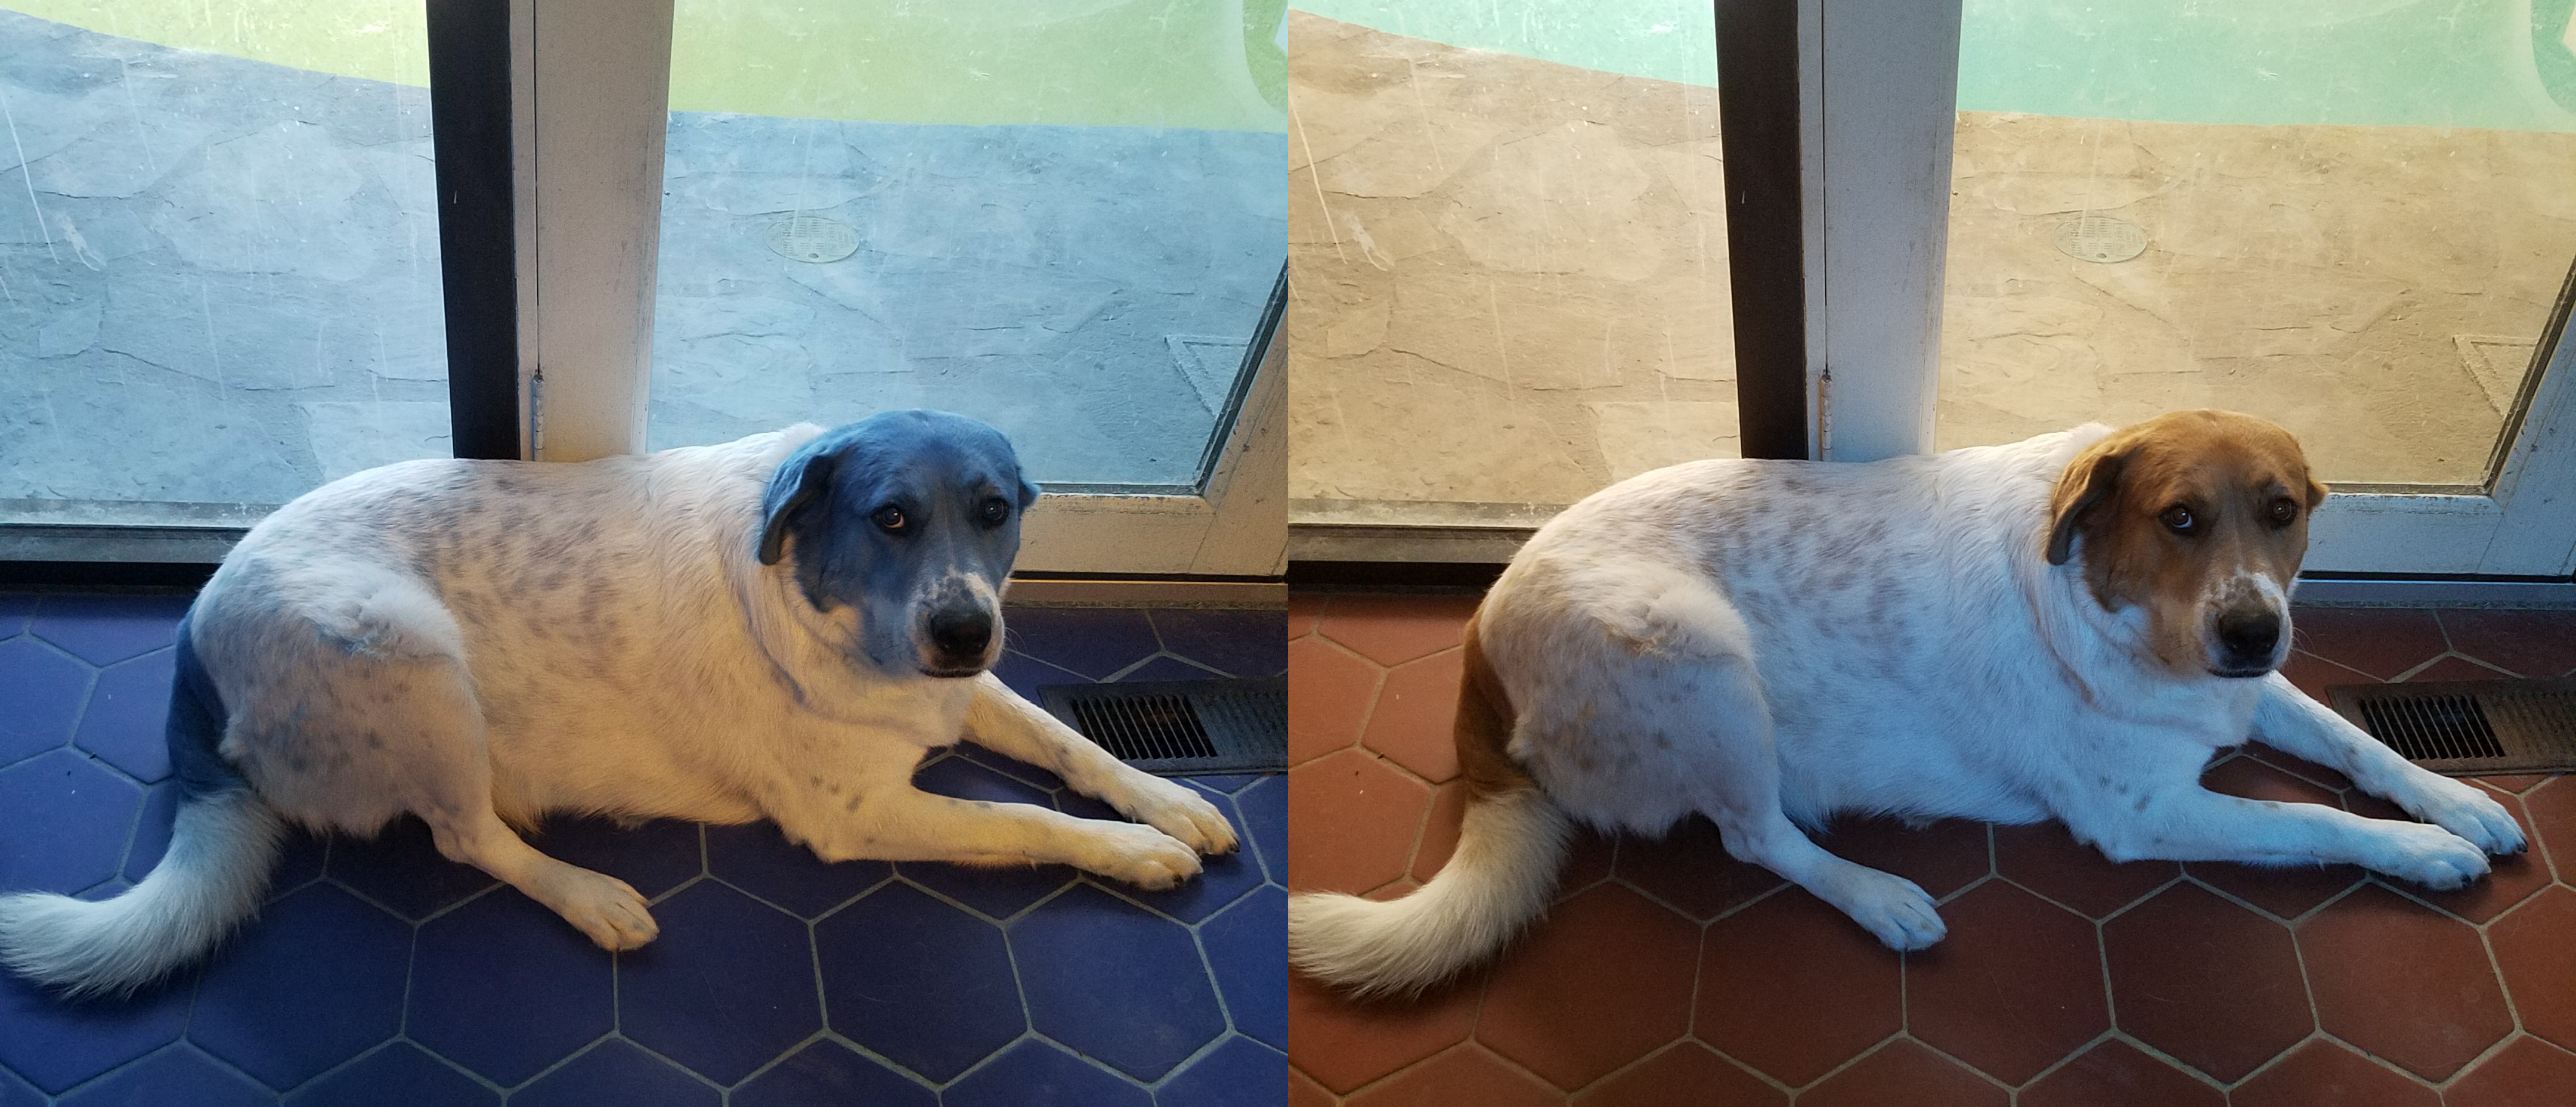

In [ ]:
import cv2 as cv
from skimage import io
from google.colab.patches import cv2_imshow
image  = io.imread(filterdf['clean_url'][8008])
image_2 = cv.cvtColor(image,cv.COLOR_BGR2RGB)
final_frame = cv.hconcat((image,image_2))
cv2_imshow(final_frame)

In [ ]:
agelist = []
for i in range(len(alldata['exact_age'])):
  if alldata['primaryBreed'][i] == 'American Pit Bull Terrier':
    agelist.append(alldata['exact_age'][i]/13)


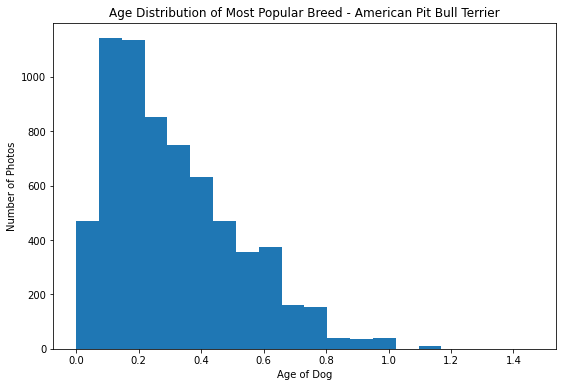

In [ ]:
import matplotlib.pyplot as plt

age_data = [number for number in alldata['exact_age'].values if str(number) != 'nan']
plt.figure(figsize = (9,6))
plt.hist(agelist,bins=20)
plt.ylabel('Number of Photos')
plt.xlabel('Age of Dog')
plt.title('Age Distribution of Most Popular Breed - American Pit Bull Terrier')
plt.savefig('agedistapb.png')

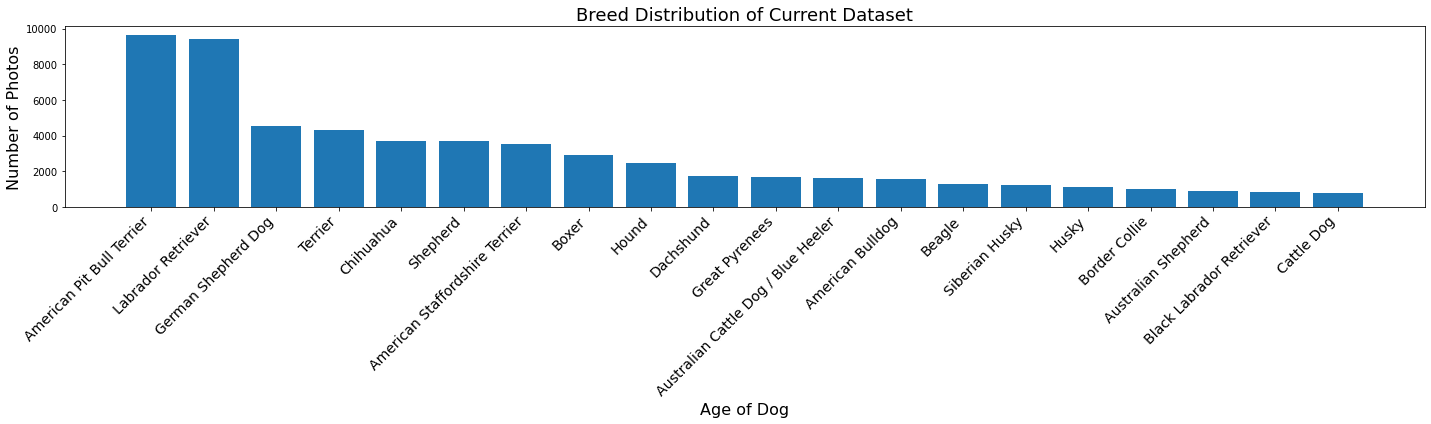

In [ ]:
breedsss = dict(alldata['primaryBreed'].value_counts())
breedsss = dict(list(breedsss.items())[:20])
plt.figure(figsize = (20,6))
plt.bar(breedsss.keys(),breedsss.values())
plt.ylabel('Number of Photos', fontsize = 16)
plt.xlabel('Age of Dog',fontsize = 16)
plt.xticks(fontsize = 14,rotation = 45, ha = 'right')
plt.title('Breed Distribution of Current Dataset',fontsize = 18)
plt.tight_layout()
plt.savefig('breeddist.png')

In [ ]:
dict(breed)

{'American Bulldog': 1563,
 'American Pit Bull Terrier': 9641,
 'American Staffordshire Terrier': 3551,
 'Australian Cattle Dog / Blue Heeler': 1612,
 'Australian Shepherd': 858,
 'Beagle': 1293,
 'Black Labrador Retriever': 812,
 'Border Collie': 994,
 'Boxer': 2928,
 'Cattle Dog': 765,
 'Chihuahua': 3689,
 'Dachshund': 1702,
 'German Shepherd Dog': 4549,
 'Great Pyrenees': 1648,
 'Hound': 2456,
 'Husky': 1110,
 'Labrador Retriever': 9392,
 'Shepherd': 3680,
 'Siberian Husky': 1227,
 'Terrier': 4325}

Text(0.5, 0, 'Age of Dog')

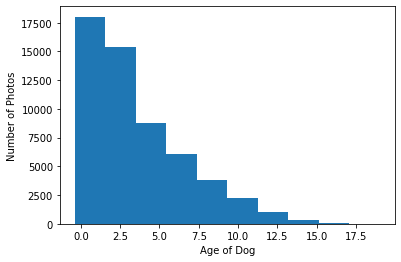

In [ ]:
plt.hist(alldata['exact_age'].values)
plt.ylabel('Number of Photos')
plt.xlabel('Age of Dog')

In [ ]:
edd =list(dict(alldata['exact_age'].value_counts()))

In [ ]:
count = 0
for i in range(len(alldata['exact_age'])):
  if str(alldata['exact_age'][i]) != '' and str(alldata['exact_age'][i]) != 'nan' and str(alldata['exact_age'][i]) != 'none' and str(alldata['exact_age'][i]) != 'None':
    count +=1
print(count)

In [ ]:
print(count)

55482


#Label Distibution Encoding of Age

0.5699175434306182
0.7978845608028654


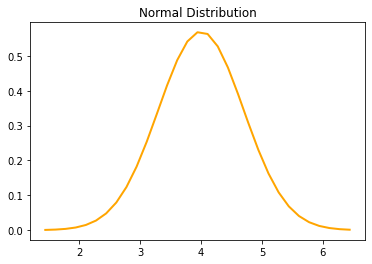

In [ ]:
import scipy.stats
import numpy as np
model = scipy.stats.norm(4, .7)

print(model.pdf(4))


model = scipy.stats.norm(4, .5)

print(model.pdf(4))
mu, sigma = 4, 0.7 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)


#3count, bins, ignored = plt.hist(s, 30, density=True, color = 'purple')
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='orange')
plt.title('Normal Distribution')
plt.show()

In [ ]:
import scipy.stats

def roundage(num):
  return round(num*2) / 2

def getlabeldist(age):
  agearray = [0]*35
  age = roundage(age)
  ageindex = int(age/.5)
  dist = scipy.stats.norm(age, .4)
  agearray[ageindex] = dist.pdf(age)/2

  for i in range(1,4):
    if ageindex - i >= 0:
      agearray[ageindex - i] = dist.pdf(age-(.5 * i))/2
  
  for i in range(1,4):
    if ageindex + i <= len(agearray):
      agearray[ageindex + i] = dist.pdf(age+(.5 * i))/2

  return agearray
  




In [ ]:
getlabeldist(4)

[0,
 0,
 0,
 0,
 0,
 0.0004407446029593068,
 0.021910375616960673,
 0.2283113567362774,
 0.49867785050179086,
 0.2283113567362774,
 0.021910375616960673,
 0.0004407446029593068,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
agearray = [0]*35

In [ ]:
agearray[-2]

0

#Get Normalized Ages and Filenames

> Normalize age based on lifespans.csv, and generate the breed mapping (breed_mapping-2). 



In [ ]:
import pandas as pd

alldata = pd.read_csv('/content/rescuegroups_23.csv', index_col=0, header= 0)
lifespans =  pd.read_csv('/content/lifespans.csv', header= 0)

In [ ]:
def getnormage(row):
  try:
    lifespan = float(lifespans[row['primaryBreed']][0])
    normage = float(row['exact_age'])/lifespan 
    return normage
  except:
    return None

def getfilename(row):

  return f'/{row["filename"]}/{row.name}.jpg'

In [ ]:
alldata['full_filename'] = alldata.apply(lambda row: getfilename(row), axis=1)
alldata['norm_age'] = alldata.apply(lambda row: getnormage(row), axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lbencode = LabelEncoder()
breedlist.append('nan')
lbencode.fit(breedlist)
lbencode_mapping = dict(zip(lbencode.classes_,map(int, lbencode.transform(lbencode.classes_))))
alldata = alldata.assign(breed_mapping=lbencode.transform(alldata['primaryBreed'].astype(str)))

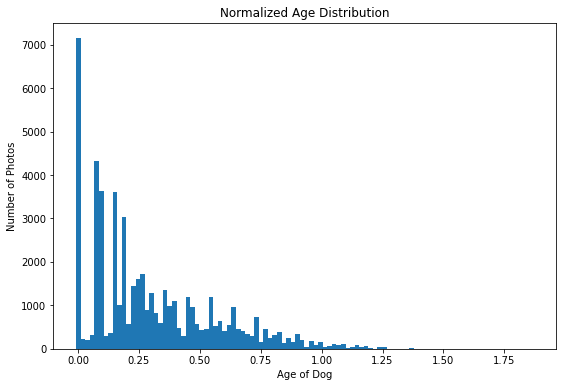

In [ ]:
import matplotlib.pyplot as plt

age_data = [number for number in alldata['norm_age'].values if str(number) != 'nan' and  str(number) != 'NaN']
plt.figure(figsize = (9,6))
plt.hist(age_data,bins=100)
plt.ylabel('Number of Photos')
plt.xlabel('Age of Dog')
plt.title('Normalized Age Distribution')
plt.savefig('agedistapb.png')

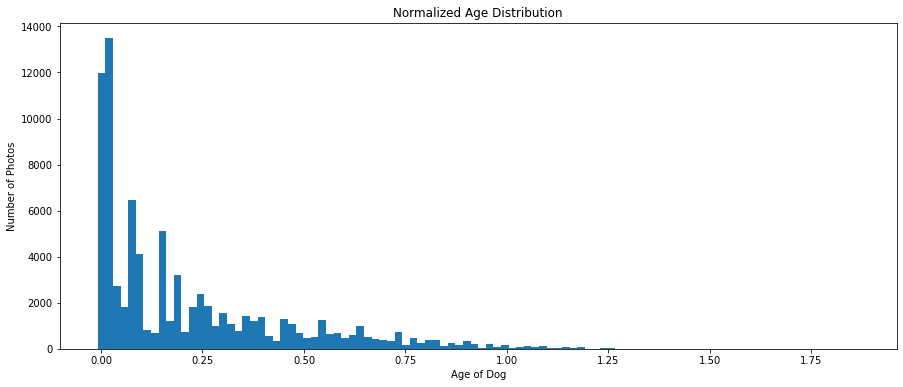

In [ ]:
import matplotlib.pyplot as plt

age_data = [number for number in alldata['norm_age'].values if str(number) != 'nan' and  str(number) != 'NaN']
plt.figure(figsize = (15,6))
plt.hist(age_data,bins=100)
plt.ylabel('Number of Photos')
plt.xlabel('Age of Dog')
plt.title('Normalized Age Distribution')
plt.savefig('agedistapb.png')

In [ ]:
import json

with open('breed_mapping_26.json', 'w') as fp:
  json.dump(lbencode_mapping, fp)

#Incorporating the Kaggle Dataset into my data format

In [ ]:
import pandas as pd
kaggletest = pd.read_csv('/test.csv', header= 0)
kaggletrain = pd.read_csv('/train.csv',header= 0)

In [ ]:
breedlabel = pd.read_csv('/BreedLabels.csv', index_col=0, header= 0)

In [ ]:
breedlabel = breedlabel[breedlabel['Type']==1]
kaggletrain = kaggletrain[kaggletrain['Type']==1]
kaggletest = kaggletest[kaggletest['Type']==1]

In [ ]:
from fuzzywuzzy import fuzz, process

for i in range(1,len(breedlabel)):
  entry = breedlabel['BreedName'][i]
  if entry not in breedlist:
    listofbreedmatch = process.extract(entry, breedlist, limit=1)
    breedlabel.at[i, 'BreedName'] = listofbreedmatch[0][0]
    print("Current: {0}. New: {1}".format(entry,listofbreedmatch))

In [ ]:
for i in range(len(alldata['primaryBreed'])):
  if alldata['primaryBreed'][i] == 'Corgi':
    alldata.at[i, 'primaryBreed'] = 'Pembroke Welsh Corgi'
  if alldata['primaryBreed'][i] == 'Eskimo Dog':
    alldata.at[i, 'primaryBreed'] = 'American Eskimo Dog'
  if alldata['primaryBreed'][i] == 'Husky':
    alldata.at[i, 'primaryBreed'] = 'Siberian Husky'

In [ ]:
newfolders = list(set(list(breedlabel['BreedName'].unique())) - set(list(alldata['primaryBreed'].unique())))
print(newfolders)

newfolder = [entry.replace(' ','-').replace("'","-") for entry in newfolders]
print(newfolder)

In [ ]:
import boto3
access_Key = "Key"
secret_Access_Key = "Secret"

s3 = boto3.client('s3', aws_access_key_id= access_Key, aws_secret_access_key=secret_Access_Key)
for breed in newfolder:
  folderpath = breed + '/'
  response = s3.put_object(Bucket = 'dogshelterimages',Body = '', Key = folderpath)
  print(response)

response = s3.put_object(Bucket = 'dogshelterimages',Body = '', Key = 'misc/')


In [ ]:
kaggletrain  = kaggletrain.reset_index()
kaggletest = kaggletest.reset_index()

In [ ]:
name = []
ages = []
Breed1 = []
Breed2 = []
Gender = []
filename = []

for i in range(len(kaggletrain)):
  photonum = int(kaggletrain['PhotoAmt'][i])
  age = int(kaggletrain['Age'][i])/12
  if photonum > 0:
    for k in range(1,photonum+1):
      filename_ = f'train_images/{kaggletrain["PetID"][i]}-{k}.jpg'
      name.append(kaggletrain['Name'][i])
      ages.append(age)
      Breed1.append(kaggletrain['Breed1'][i])
      Breed2.append(kaggletrain['Breed2'][i])
      Gender.append(kaggletrain['Gender'][i])
      filename.append(filename_)

In [ ]:
for i in range(len(kaggletest)):
  photonum = int(kaggletest['PhotoAmt'][i])
  age = int(kaggletest['Age'][i])/12
  if photonum > 0:
    for k in range(1,photonum+1):
      filename_ = f'test_images/{kaggletest["PetID"][i]}-{k}.jpg'
      name.append(kaggletest['Name'][i])
      ages.append(age)
      Breed1.append(kaggletest['Breed1'][i])
      Breed2.append(kaggletest['Breed2'][i])
      Gender.append(kaggletest['Gender'][i])
      filename.append(filename_)

In [ ]:
source = ['Kaggle']*len(filename)

In [ ]:
kaggledata = pd.DataFrame(list(zip(name,ages,Breed1,Breed2,Gender,filename,source)),columns = ['name','exact_age','primaryBreed','secondaryBreed','sex','clean_url','source'])

In [ ]:
kaggledata['primaryBreed'] = kaggledata['primaryBreed'].astype(str)
kaggledata['secondaryBreed'] = kaggledata['secondaryBreed'].astype(str)
kaggledata

name  exact_age  ...                     clean_url  source
0      Brisco   0.083333  ...  train_images/3422e4906-1.jpg  Kaggle
1      Brisco   0.083333  ...  train_images/3422e4906-2.jpg  Kaggle
2      Brisco   0.083333  ...  train_images/3422e4906-3.jpg  Kaggle
3      Brisco   0.083333  ...  train_images/3422e4906-4.jpg  Kaggle
4      Brisco   0.083333  ...  train_images/3422e4906-5.jpg  Kaggle
...       ...        ...  ...                           ...     ...
37307    Spot   2.500000  ...   test_images/83432904d-1.jpg  Kaggle
37308    Spot   2.500000  ...   test_images/83432904d-2.jpg  Kaggle
37309  Smokey   2.000000  ...   test_images/fd80b8c80-1.jpg  Kaggle
37310  Smokey   2.000000  ...   test_images/fd80b8c80-2.jpg  Kaggle
37311  Smokey   2.000000  ...   test_images/fd80b8c80-3.jpg  Kaggle

[37312 rows x 7 columns]

In [ ]:
kaggledata['full_filename'] = kaggledata['primaryBreed']

for i in range(len(kaggledata)):
  current1 = int(kaggledata['primaryBreed'][i])
  current2 = int(kaggledata['secondaryBreed'][i])
  currentname = kaggledata['clean_url'][i]
  currentname = currentname[currentname.find("/")+1:]
  try:
    currentbreed = breedlabel['BreedName'][current1]
    currentbreed = currentbreed.replace(' / ', '-').replace(' ', '-').replace("'",'-')
    kaggledata.at[i, 'filename'] = f'/{currentbreed}/{currentname}'
    kaggledata.at[i, 'breed_mapping'] = lbencoder[breedlabel['BreedName'][current1]]
    kaggledata.at[i, 'primaryBreed'] = breedlabel['BreedName'][current1]
  except Exception as e:
    kaggledata.at[i, 'filename'] = f'/misc/{currentname}'
    print(current1)
    print(e)
    kaggledata.at[i, 'primaryBreed'] = None
    kaggledata.at[i, 'breed_mapping'] = None

  try:
    kaggledata.at[i, 'secondaryBreed'] = breedlabel['BreedName'][current2]
  except Exception as e:
    print(current2)
    print(e)
    kaggledata.at[i, 'secondaryBreed'] = None
    print('second')

  

In [ ]:
import pandas as pd

alldata  = pd.read_csv('/rescuegroups_26.csv', index_col = 0, header = 0)
lifespans = pd.read_csv('/lifespans.csv', header = 0)

In [ ]:
kaggledata = kaggledata[kaggledata['sex']<3]
kaggledata['sex'] = kaggledata['sex'].astype(str)
kaggledata = kaggledata.reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
kaggledata.drop(labels=['index'],axis = 1)

name  exact_age  ...                      filename breed_mapping
0      Brisco   0.083333  ...  /Mixed-Breed/3422e4906-1.jpg         167.0
1      Brisco   0.083333  ...  /Mixed-Breed/3422e4906-2.jpg         167.0
2      Brisco   0.083333  ...  /Mixed-Breed/3422e4906-3.jpg         167.0
3      Brisco   0.083333  ...  /Mixed-Breed/3422e4906-4.jpg         167.0
4      Brisco   0.083333  ...  /Mixed-Breed/3422e4906-5.jpg         167.0
...       ...        ...  ...                           ...           ...
31611    Spot   2.500000  ...  /Mixed-Breed/83432904d-1.jpg         167.0
31612    Spot   2.500000  ...  /Mixed-Breed/83432904d-2.jpg         167.0
31613  Smokey   2.000000  ...  /Mixed-Breed/fd80b8c80-1.jpg         167.0
31614  Smokey   2.000000  ...  /Mixed-Breed/fd80b8c80-2.jpg         167.0
31615  Smokey   2.000000  ...  /Mixed-Breed/fd80b8c80-3.jpg         167.0

[31616 rows x 10 columns]

In [ ]:
kaggledata['full_filename'] = kaggledata['filename']

for i in range(len(kaggledata)):
  if int(kaggledata['sex'][i]) == 1:
    kaggledata.at[i,'sex'] = "Male"
  elif int(kaggledata['sex'][i]) == 2:
    kaggledata.at[i,'sex'] = "Female"
  prefix = kaggledata['full_filename'][i]
  prefix = prefix[1:]
  prefix = prefix[:prefix.find('/')]
  kaggledata.at[i,'filename'] = prefix

In [ ]:
kaggledata['norm_age'] = kaggledata.apply(lambda row: getnormage(row), axis=1)

In [ ]:
alldata = pd.concat([alldata,kaggledata])

In [ ]:
kaggledata = kaggledata.drop(labels=['index'], axis=1)
kaggledata

name  exact_age primaryBreed  ...     filename breed_mapping  norm_age
0      Brisco   0.083333  Mixed Breed  ...  Mixed-Breed         167.0  0.006667
1      Brisco   0.083333  Mixed Breed  ...  Mixed-Breed         167.0  0.006667
2      Brisco   0.083333  Mixed Breed  ...  Mixed-Breed         167.0  0.006667
3      Brisco   0.083333  Mixed Breed  ...  Mixed-Breed         167.0  0.006667
4      Brisco   0.083333  Mixed Breed  ...  Mixed-Breed         167.0  0.006667
...       ...        ...          ...  ...          ...           ...       ...
31611    Spot   2.500000  Mixed Breed  ...  Mixed-Breed         167.0  0.200000
31612    Spot   2.500000  Mixed Breed  ...  Mixed-Breed         167.0  0.200000
31613  Smokey   2.000000  Mixed Breed  ...  Mixed-Breed         167.0  0.160000
31614  Smokey   2.000000  Mixed Breed  ...  Mixed-Breed         167.0  0.160000
31615  Smokey   2.000000  Mixed Breed  ...  Mixed-Breed         167.0  0.160000

[31616 rows x 11 columns]

In [ ]:
alldata

originalUrl  ...  breed_mapping
0      https:\/\/s3.amazonaws.com\/filestore.rescuegr...  ...           48.0
1      https:\/\/s3.amazonaws.com\/filestore.rescuegr...  ...           48.0
2      https:\/\/s3.amazonaws.com\/filestore.rescuegr...  ...           48.0
3      https:\/\/s3.amazonaws.com\/filestore.rescuegr...  ...           48.0
4      https:\/\/s3.amazonaws.com\/filestore.rescuegr...  ...          156.0
...                                                  ...  ...            ...
31611                                                NaN  ...          167.0
31612                                                NaN  ...          167.0
31613                                                NaN  ...          167.0
31614                                                NaN  ...          167.0
31615                                                NaN  ...          167.0

[115043 rows x 23 columns]

In [ ]:
import pandas as pd
alldata = pd.read_csv('/content/rescuegroups_28.csv', index_col= 0, header = 0, dtype ={'originalUrl':str, 'lastUpdated': str, 'animalLocation': str, 'descriptionPlain': str, 'mixed':str, 'age':str, 'birthdate':str, 'size':str})
kaggledata = pd.read_csv('/content/kaggledata_28.csv',index_col = 0, header = 0)

In [ ]:
import boto3
from botocore.exceptions import NoCredentialsError

access_Key = "Key"
secret_Access_Key = "Secret"

def upload_kaggle_photo(df,row,bucket):
  actualfilepath = '/content/' + df['clean_url'][row]

  key = df['full_filename'][row]
  key = key[1:]

  s3 = boto3.client('s3', aws_access_key_id= access_Key, aws_secret_access_key=secret_Access_Key)
  try:
    s3.upload_file(actualfilepath,bucket,key)
    print(row)
  except FileNotFoundError:
    print('no file at link')
  except NoCredentialsError:
    print('credential error')
  

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import time
start = time.time()
with ThreadPoolExecutor() as executor:
  for i in range(len(kaggledata['filename'])+1):
    executor.submit(upload_kaggle_photo,kaggledata,i, 'dogshelterimages')
end = time.time()
print(end-start)

In [ ]:
alldata.to_csv('alldata_28.csv')
kaggledata.to_csv('kaggle_28.csv')

# Incorporating Carol's Dataset

In [ ]:
import pandas as pd
petangodf = pd.read_csv('/content/petango images - all cities.csv', header = 0)
sourcepet = ['Petango']*len(petangodf)
newdf = pd.DataFrame()
for i in range(len(petangodf)):
  entry = petangodf['age'][i]
  bentry = petangodf['breed'][i]

  entry = entry.split(',')
  age = 0
  for num in entry:
    if 'm' in num:
      num = num.replace('m','')
      months = int(num)/12
      age += months

    if 'y' in num:
      num = num.replace('y','')
      years = num
      age += float(years)

    if 'd' in num:
      num = num.replace('d','')
      days = int(num)/365 
      age += days 
  newdf.at[i,'exact_age'] = age
  commac = bentry.count(',')
  count = 1

  if commac == 0:
    primaryBreed = bentry
  else:
    while commac >= 2:
      for breed in petangobc:
        if breed in bentry:
          bentry = bentry.replace(breed,breeddictp[breed])
          commac = bentry.count(',')
      count +=1
      if count > 4:
        break
    

    primaryBreed = bentry[:bentry.find(',')].strip()

    mix = True
    if bentry[bentry.find(',')+1:].strip() == 'mix':
      secondaryBreed = None
    else:
      secondaryBreed = bentry[bentry.find(',')+1:].strip()
      if ','  in secondaryBreed:
        newentry = secondaryBreed
        secondaryBreed = newentry[:newentry.find(',')].strip()
  newdf.at[i,'originalref'] = petangodf['breed'][i] 
  newdf.at[i,'primaryBreed'] = primaryBreed
  newdf.at[i,'secondaryBreed'] = secondaryBreed
  newdf.at[i,'clean_url'] = petangodf['img_url'][i]
  print(f'Original:{bentry}  || Primary:{primaryBreed} and Secondary:{secondaryBreed}')
    

In [ ]:
entry = '10m, 10d'

entry = entry.split(',')
age = 0
for num in entry:
  if 'm' in num:
    num = num.replace('m','')
    months = int(num)/12
    age += months

  if 'y' in num:
    num = num.replace('y','')
    years = num
    age += years

  if 'd' in num:
    num = num.replace('d','')
    days = int(num)/365 
    age += days 

print(age)


0.860730593607306


In [ ]:
bentry = 'american staffordshire terrier, staffordshire bull terrier, american pit bull terrier'
commac = bentry.count(',')

commac = bentry.count(',')
count = 1
while commac >= 2:
  for breed in petangobc:
    if breed in bentry:
      bentry = bentry.replace(breed,breeddictp[breed])
      commac = bentry.count(',')
  count +=1
  if count > 4:
    break

print(bentry)
primaryBreed = bentry[:bentry.find(',')].strip()
print(primaryBreed)
mix = True
if bentry[bentry.find(','):] == 'mix':
  secondaryBreed = None
else:
  secondaryBreed = bentry[bentry.find(',')+1:].strip()
  if ','  in secondaryBreed:
    newentry = secondaryBreed
    print(newentry[:newentry.find(',')].strip())

american staffordshire staffordshire bull terrier american pit bull terrier terrier
american staffordshire staffordshire bull terrier american pit bull terrier terrie


In [ ]:
https://www.petango.com/pet_search_results?speciesId=1&breedId=undefined&location=28277&distance=50

In [ ]:
import requests
from bs4 import BeautifulSoup
from dateutil import parser
import datetime
#from fuzzywuzzy import fuzz, process



In [ ]:
petangob = [breed.text.strip().upper().lower() for breed in animaldata]

In [ ]:
petangobc = [breed for breed in petangob if ',' in breed]

In [ ]:
def getname(entry):
  commacount = entry.count(',')
  if 'mixed breed' in entry:
    return 'mixed breed'
  if commacount ==1:
    actualname = entry[entry.find(',')+1:]+' ' +entry[:entry.find(',')]
    actualname = actualname.replace('  ',' ').strip()
    return actualname
  elif commacount == 2:
    lastpart = entry[:entry.find(',')].strip()
    #print(lastpart)
    newentry = entry[entry.find(',')+1:]
    #print(newentry)
    middlepart = newentry[:newentry.find(',')].strip()
    #print(middlepart)
    firstpart = newentry[newentry.find(',')+1:].strip()
    actualname = f'{firstpart} {middlepart} {lastpart}'
    actualname = actualname.replace('  ',' ')
    return actualname

In [ ]:
getname('terrier, english staffordshire')

'english staffordshire terrier'

In [ ]:
actualnames = [getname(breed) for breed in petangobc]

In [ ]:
breeddictp = {key:value for key,value in zip(petangobc,actualnames)}

In [ ]:
import pandas as pd

In [ ]:
fixeddf = pd.read_csv('/content/checking.csv',index_col=0,header=0)

for i in range(len(fixeddf)):
  if fixeddf['originalref'][i].strip() in petangobc:
    fixeddf.at[i,'primaryBreed'] = breeddictp[fixeddf['originalref'][i].strip()]
    fixeddf.at[i,'secondaryBreed'] = None
  
  if ',' not in fixeddf['originalref'][i].strip():
    fixeddf.at[i,'primaryBreed'] = fixeddf['originalref'][i].strip()
    fixeddf.at[i,'secondaryBreed'] = None

In [ ]:
for i in range(len(fixeddf['primaryBreed'])):
  if fixeddf['primaryBreed'][i] == 'Pit Bull Terrier':
    fixeddf.at[i, 'primaryBreed'] = 'American Pit Bull Terrier'
  if fixeddf['primaryBreed'][i] == 'bulldog':
    fixeddf.at[i, 'primaryBreed'] = 'English Bulldog'
  if fixeddf['primaryBreed'][i] == 'Red Heeler':
    fixeddf.at[i, 'primaryBreed'] = 'Australian Cattle Dog / Blue Heeler'
  if fixeddf['primaryBreed'][i] == 'Elkhound':
    fixeddf.at[i, 'primaryBreed'] = 'Norwegian Elkhound'
  if fixeddf['primaryBreed'][i] == 'Boerboel Mastiff':
    fixeddf.at[i, 'primaryBreed'] = 'Boerboel'
  if fixeddf['primaryBreed'][i] == 'Cane Corso Mastiff':
    fixeddf.at[i, 'primaryBreed'] = 'Cane Corso'
  if fixeddf['primaryBreed'][i] == 'Chinese Crested-Hairless' or fixeddf['primaryBreed'][i] == 'Chinese Crested-Powder Puff':
    fixeddf.at[i, 'primaryBreed'] = 'Chinese Crested Dog'
  if fixeddf['primaryBreed'][i] == 'merican Blue Heeler American Blue Heeler':
    fixeddf.at[i, 'primaryBreed'] = 'Australian Cattle Dog / Blue Heeler'
  if fixeddf['primaryBreed'][i] == 'unknown':
    fixeddf.at[i, 'primaryBreed'] = ''
  if fixeddf['primaryBreed'][i] == 'Houn':
    fixeddf.at[i, 'primaryBreed'] = 'Hound'
  if fixeddf['primaryBreed'][i] == 'Wirehaired Fox Terrier':
    fixeddf.at[i, 'primaryBreed'] = 'Wirehaired Terrier'
  if fixeddf['primaryBreed'][i] == 'Australian Cattle Dog\/Blue Heeler':
    fixeddf.at[i, 'primaryBreed'] = 'Australian Cattle Dog / Blue Heeler'
  if fixeddf['primaryBreed'][i] == 'belgian shepherd dog':
    fixeddf.at[i, 'primaryBreed'] = 'Belgian Shepherd / Sheepdog'
  if fixeddf['primaryBreed'][i] == 'miniature smooth haired dachshund' or fixeddf['primaryBreed'][i] == 'miniature long haired dachshund' or fixeddf['primaryBreed'][i] ==  'miniature wire haired dachshund':
    fixeddf.at[i, 'primaryBreed'] = 'Miniature Dachshund'
  if fixeddf['primaryBreed'][i] == 'alaskan husky':
    fixeddf.at[i,'primaryBreed'] = 'Alaskan Malamute'
  if fixeddf['primaryBreed'][i] == 'american blue heeler':
    fixeddf.at[i,'primaryBreed'] = 'Australian Cattle Dog'
  if fixeddf['primaryBreed'][i] == 'belgian malinois':
    fixeddf.at[i,'primaryBreed'] = 'Belgian Shepherd / Malinois'
  if fixeddf['primaryBreed'][i] == 'toy poodle':
    fixeddf.at[i,'primaryBreed'] = 'Miniature Poodle'
  if fixeddf['primaryBreed'][i] == 'appenzeller sennenhund':
    fixeddf.at[i,'primaryBreed'] = 'appenzeller mountain dog'
  if fixeddf['primaryBreed'][i] == 'english toy terrier':
    fixeddf.at[i,'primaryBreed'] = 'Toy Manchester Terrier' 
  if fixeddf['primaryBreed'][i] == 'white shepherd':
    fixeddf.at[i,'primaryBreed'] = 'White German Shepherd' 
  if fixeddf['primaryBreed'][i] == 'english staffordshire terrier':
    fixeddf.at[i,'primaryBreed'] = 'Staffordshire Bull Terrier'
  if fixeddf['primaryBreed'][i] == 'pit bull terrier':
    fixeddf.at[i,'primaryBreed'] = 'american pit bull terrier'
  if fixeddf['primaryBreed'][i] == 'king german shepherd':
    fixeddf.at[i,'primaryBreed'] = 'german shepherd'
  if fixeddf['primaryBreed'][i] == 'old english sheepdog':
    fixeddf.at[i,'primaryBreed'] = 'Old English Sheepdog'

In [ ]:
from fuzzywuzzy import fuzz, process

for i in range(len(fixeddf['primaryBreed'])):
  entry = fixeddf['primaryBreed'][i]
  #print(entry)
  if not entry in breedlist and entry != '' and str(entry) != 'nan':
    listofbreedmatch = process.extract(entry, breedlist, limit=1)
    fixeddf.at[i,'primaryBreed'] = listofbreedmatch[0][0]
    #print(f'known:{entry} || closest: {listofbreedmatch}')

In [ ]:
lifespans = pd.read_csv('/content/lifespans.csv', header= 0)

In [ ]:
petangodf=fixeddf[fixeddf['primaryBreed']!='']

In [ ]:
petangodf.reset_index(inplace=True,drop=True)

In [ ]:
for i in range(len(petangodf)):
  petangodf.at[i,'norm_age'] = float(petangodf['exact_age'][i])/lifespans[petangodf['primaryBreed'][i]][0]
  petangodf.at[i,'ID'] = abs(hash(petangodf['clean_url'][i]) % (10**8))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
print(len(petangodf['ID'].unique()))

9771


In [ ]:
petangodf.drop(labels = [3324], axis=0, inplace=True)
petangodf.reset_index(drop = True,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
iddict = dict(petangodfnew['ID'].value_counts())

In [ ]:
for item in iddict.keys():
  if iddict[item] == 2:
    print(item)

In [ ]:
newdf = petangodfnew[petangodfnew['ID'] == 86616912.0]

In [ ]:
newdf

exact_age  ...  norm_age
3324        2.0  ...  0.181818

[1 rows x 8 columns]

In [ ]:
petangodfnew = petangodf.drop(petangodf.index[[3324]])

In [ ]:
petangodfnew.reset_index(drop=True,inplace=True)

In [ ]:
for i in range(len(petangodf)):
  #fixeddf.at[i,'norm_age'] = float(fixeddf['exact_age'][i])/lifespans[fixeddf['primaryBreed'][0]]
  breed = petangodf['primaryBreed'][i].replace(' / ','-').replace(' ','-').replace(',','-').replace("'",'-')
  petangodf.loc[i,'full_filename'] = f'{breed}/{str(int(petangodf["ID"][i]))}.jpg'
  petangodf.loc[i,'filename'] = breed

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
breedmappingdict= {"Affenpinscher": 0, "Afghan Hound": 1, "Airedale Terrier": 2, "Akbash": 3, "Akita": 4, "Alaskan Malamute": 5, "American Bulldog": 6, "American Bully": 7, "American Eskimo Dog": 8, "American Foxhound": 9, "American Hairless Terrier": 10, "American Pit Bull Terrier": 11, "American Staffordshire Terrier": 12, "American Water Spaniel": 13, "Anatolian Shepherd": 14, "Appenzell Mountain Dog": 15, "Aussiedoodle": 16, "Australian Cattle Dog / Blue Heeler": 17, "Australian Kelpie": 18, "Australian Shepherd": 19, "Australian Terrier": 20, "Basenji": 21, "Basset Hound": 22, "Beagle": 23, "Bearded Collie": 24, "Beauceron": 25, "Bedlington Terrier": 26, "Belgian Shepherd / Laekenois": 27, "Belgian Shepherd / Malinois": 28, "Belgian Shepherd / Sheepdog": 29, "Belgian Shepherd / Tervuren": 30, "Bernedoodle": 31, "Bernese Mountain Dog": 32, "Bichon Frise": 33, "Black Labrador Retriever": 34, "Black Mouth Cur": 35, "Black Russian Terrier": 36, "Black and Tan Coonhound": 37, "Bloodhound": 38, "Blue Lacy": 39, "Bluetick Coonhound": 40, "Boerboel": 41, "Bolognese": 42, "Border Collie": 43, "Border Terrier": 44, "Borzoi": 45, "Boston Terrier": 46, "Bouvier des Flandres": 47, "Boxer": 48, "Boykin Spaniel": 49, "Briard": 50, "Brittany Spaniel": 51, "Brussels Griffon": 52, "Bull Terrier": 53, "Bullmastiff": 54, "Cairn Terrier": 55, "Canaan Dog": 56, "Cane Corso": 57, "Cardigan Welsh Corgi": 58, "Carolina Dog": 59, "Catahoula Leopard Dog": 60, "Cattle Dog": 61, "Caucasian Sheepdog / Caucasian Ovtcharka": 62, "Cavachon": 63, "Cavalier King Charles Spaniel": 64, "Cavapoo": 65, "Chesapeake Bay Retriever": 66, "Chihuahua": 67, "Chinese Crested Dog": 68, "Chinese Foo Dog": 69, "Chinook": 70, "Chiweenie": 71, "Chocolate Labrador Retriever": 72, "Chow Chow": 73, "Cirneco dell'Etna": 74, "Clumber Spaniel": 75, "Cockapoo": 76, "Cocker Spaniel": 77, "Collie": 78, "Coonhound": 79, "Coton de Tulear": 80, "Curly-Coated Retriever": 81, "Dachshund": 82, "Dalmatian": 83, "Dandie Dinmont Terrier": 84, "Doberman Pinscher": 85, "Dogo Argentino": 86, "Dogue de Bordeaux": 87, "Dutch Shepherd": 88, "English Bulldog": 89, "English Cocker Spaniel": 90, "English Coonhound": 91, "English Foxhound": 92, "English Pointer": 93, "English Setter": 94, "English Shepherd": 95, "English Springer Spaniel": 96, "English Toy Spaniel": 97, "Entlebucher": 98, "Feist": 99, "Field Spaniel": 100, "Fila Brasileiro": 101, "Finnish Lapphund": 102, "Finnish Spitz": 103, "Flat-Coated Retriever": 104, "Fox Terrier": 105, "Foxhound": 106, "French Bulldog": 107, "Galgo Spanish Greyhound": 108, "German Pinscher": 109, "German Shepherd Dog": 110, "German Shorthaired Pointer": 111, "German Spitz": 112, "German Wirehaired Pointer": 113, "Giant Schnauzer": 114, "Glen of Imaal Terrier": 115, "Golden Retriever": 116, "Goldendoodle": 117, "Gordon Setter": 118, "Great Dane": 119, "Great Pyrenees": 120, "Greater Swiss Mountain Dog": 121, "Greyhound": 122, "Hamiltonstovare": 123, "Harrier": 124, "Havanese": 125, "Hound": 126, "Hovawart": 127, "Ibizan Hound": 128, "Icelandic Sheepdog": 129, "Illyrian Sheepdog": 130, "Irish Setter": 131, "Irish Terrier": 132, "Irish Water Spaniel": 133, "Irish Wolfhound": 134, "Italian Greyhound": 135, "Jack Russell Terrier": 136, "Japanese Chin": 137, "Jindo": 138, "Kai Dog": 139, "Karelian Bear Dog": 140, "Keeshond": 141, "Kerry Blue Terrier": 142, "Kishu": 143, "Klee Kai": 144, "Komondor": 145, "Kuvasz": 146, "Kyi Leo": 147, "Labradoodle": 148, "Labrador Retriever": 149, "Lakeland Terrier": 150, "Lancashire Heeler": 151, "Leonberger": 152, "Lhasa Apso": 153, "Lowchen": 154, "Lurcher": 155, "Maltese": 156, "Maltipoo": 157, "Manchester Terrier": 158, "Maremma Sheepdog": 159, "Mastiff": 160, "McNab": 161, "Miniature Bull Terrier": 162, "Miniature Dachshund": 163, "Miniature Pinscher": 164, "Miniature Poodle": 165, "Miniature Schnauzer": 166, "Mixed Breed": 167, "Morkie": 168, "Mountain Cur": 169, "Mountain Dog": 170, "Munsterlander": 171, "Neapolitan Mastiff": 172, "New Guinea Singing Dog": 173, "Newfoundland Dog": 174, "Norfolk Terrier": 175, "Norwegian Buhund": 176, "Norwegian Elkhound": 177, "Norwegian Lundehund": 178, "Norwich Terrier": 179, "Nova Scotia Duck Tolling Retriever": 180, "Old English Sheepdog": 181, "Otterhound": 182, "Papillon": 183, "Parson Russell Terrier": 184, "Patterdale Terrier / Fell Terrier": 185, "Pekingese": 186, "Pembroke Welsh Corgi": 187, "Peruvian Inca Orchid": 188, "Petit Basset Griffon Vendeen": 189, "Pharaoh Hound": 190, "Plott Hound": 191, "Pointer": 192, "Polish Lowland Sheepdog": 193, "Pomeranian": 194, "Pomsky": 195, "Poodle": 196, "Portuguese Podengo": 197, "Portuguese Water Dog": 198, "Presa Canario": 199, "Pug": 200, "Puggle": 201, "Puli": 202, "Pumi": 203, "Pyrenean Shepherd": 204, "Rat Terrier": 205, "Redbone Coonhound": 206, "Retriever": 207, "Rhodesian Ridgeback": 208, "Rottweiler": 209, "Rough Collie": 210, "Saint Bernard": 211, "Saluki": 212, "Samoyed": 213, "Sarplaninac": 214, "Schipperke": 215, "Schnauzer": 216, "Schnoodle": 217, "Scottish Deerhound": 218, "Scottish Terrier": 219, "Sealyham Terrier": 220, "Setter": 221, "Shar Pei": 222, "Sheep Dog": 223, "Sheepadoodle": 224, "Shepherd": 225, "Shetland Sheepdog / Sheltie": 226, "Shiba Inu": 227, "Shih Tzu": 228, "Shih poo": 229, "Shollie": 230, "Siberian Husky": 231, "Silky Terrier": 232, "Skye Terrier": 233, "Sloughi": 234, "Smooth Collie": 235, "Smooth Fox Terrier": 236, "South Russian Ovtcharka": 237, "Spaniel": 238, "Spanish Water Dog": 239, "Spinone Italiano": 240, "Spitz": 241, "Staffordshire Bull Terrier": 242, "Standard Poodle": 243, "Standard Schnauzer": 244, "Sussex Spaniel": 245, "Swedish Vallhund": 246, "Tennessee Treeing Brindle": 247, "Terrier": 248, "Thai Ridgeback": 249, "Tibetan Mastiff": 250, "Tibetan Spaniel": 251, "Tibetan Terrier": 252, "Tosa Inu": 253, "Toy Fox Terrier": 254, "Toy Manchester Terrier": 255, "Treeing Walker Coonhound": 256, "Vizsla": 257, "Weimaraner": 258, "Welsh Springer Spaniel": 259, "Welsh Terrier": 260, "West Highland White Terrier / Westie": 261, "Wheaten Terrier": 262, "Whippet": 263, "White German Shepherd": 264, "Wire Fox Terrier": 265, "Wirehaired Dachshund": 266, "Wirehaired Pointing Griffon": 267, "Wirehaired Terrier": 268, "Xoloitzcuintli / Mexican Hairless": 269, "Yellow Labrador Retriever": 270, "Yorkshire Terrier": 271, "Olde English Bulldogge":273, "Canadian Eskimo Dog":274,"Toy Manchester Terrier":275, "Miniature Dachshund":276,"Carpathian Shepherd Dog":277,"Rough Collie":278,"Tennessee Treeing Brindle":279,"Karakachan Dog":280,"Royal Bahamian Potcake":281,"American Indian Dog":282, "Dingo":283, "Alapha Blue Blood Bulldog":284, "nan": 272}

#for i in range(len(petangodf)):
  #petangodf.at[i,'breed_mapping'] = breedmappingdict[petangodf['primaryBreed'][i]]

In [ ]:
petangodf.to_csv('petango_2.csv')

In [ ]:
alldata = pd.read_csv('/content/alldata_28.csv',index_col=0,header=0, dtype ={'originalUrl':str, 'lastUpdated': str, 'animalLocation': str, 'descriptionPlain': str, 'mixed':str, 'age':str, 'birthdate':str, 'size':str})
petangodf.drop(inplace=True,columns=['ID','originalref'])
alldata2 = pd.concat([alldata,petangodf])
alldata2.to_csv('alldata_aug2.csv')

#Splitting Data into Train/Test/Val

In [ ]:
import pandas as pd
alldata  = pd.read_csv('/content/alldata_aug2.csv', index_col = 0, header = 0, dtype ={'originalUrl':str, 'lastUpdated': str, 'animalLocation': str, 'descriptionPlain': str, 'mixed':str, 'age':str, 'birthdate':str, 'size':str})
alldata = alldata.dropna(subset = ['norm_age'])
alldata = alldata.drop(columns=['lastUpdated','originalUrl','name','animalLocation','animalID','descriptionPlain','mediaLastUpdated','size'])
alldata = alldata.reset_index(drop=True)

In [ ]:
for i in range(len(alldata)):
  entry = alldata['full_filename'][i]
  if entry[0] == '/':
    alldata.at[i,'full_filename'] = entry[1:]

alldata

original.resolutionX  ...  breed_mapping
0                     400.0  ...           12.0
1                     558.0  ...           67.0
2                     480.0  ...           67.0
3                     491.0  ...           17.0
4                    1536.0  ...          116.0
...                     ...  ...            ...
92695                   NaN  ...           11.0
92696                   NaN  ...          248.0
92697                   NaN  ...           11.0
92698                   NaN  ...           11.0
92699                   NaN  ...          271.0

[92700 rows x 15 columns]

In [ ]:
from verstack.stratified_continuous_split import scsplit

traindf,validdf = scsplit(alldata,stratify=alldata['norm_age'], random_state=17)

validdf.reset_index(inplace=True)

traindf.reset_index(inplace=True)

In [ ]:
traindf

index  ...  breed_mapping
0       1954  ...          149.0
1      68793  ...          167.0
2      89277  ...          160.0
3      37295  ...          243.0
4      39787  ...          119.0
...      ...  ...            ...
64884  77162  ...           89.0
64885  12809  ...           11.0
64886  50840  ...          110.0
64887  33075  ...          169.0
64888   1502  ...           48.0

[64889 rows x 16 columns]

In [ ]:
validdf,testdf = scsplit(validdf,stratify=validdf['norm_age'],test_size=.5,train_size=.5,random_state=17)

validdf.reset_index(inplace=True,drop=True)
testdf.reset_index(inplace=True,drop=True)

In [ ]:
validdf

index  ...  breed_mapping
0      27634  ...           72.0
1      23267  ...          248.0
2      83283  ...          276.0
3      74023  ...          167.0
4      85245  ...           85.0
...      ...  ...            ...
13900  30323  ...          149.0
13901  29462  ...          149.0
13902  69275  ...          167.0
13903    582  ...           82.0
13904  50744  ...           12.0

[13905 rows x 16 columns]

In [ ]:
validdf.to_csv('/valid_df2.csv')
testdf.to_csv('/test_df2.csv')
traindf.to_csv('/train_df2.csv')

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split as split

def estimate_nbins(y):
    """
    Break down target vartiable into bins.

    Args:
        y (pd.Series): stratification target variable.

    Returns:
        bins (array): bins' values.

    """
    if len(y)/10 <= 100:
        nbins = int(len(y)/10)
    else:
        nbins = 100
    bins = np.linspace(min(y), max(y), nbins)
    return bins

def combine_single_valued_bins(y_binned):
    """
    Correct the assigned bins if some bins include a single value (can not be split).

    Find bins with single values and:
        - try to combine them to the nearest neighbors within these single bins
        - combine the ones that do not have neighbors among the single values with
        the rest of the bins.

    Args:
        y_binned (array): original y_binned values.

    Returns:
        y_binned (array): processed y_binned values.

    """
    # count number of records in each bin
    y_binned_count = dict(Counter(y_binned))
    # combine the single-valued-bins with nearest neighbors
    keys_with_single_value = []
    for key, value in y_binned_count.items():
        if value == 1:
            keys_with_single_value.append(key)

    # first combine with singles in keys_with_single_values
    def combine_singles(val, lst, operator, keys_with_single_value):
        for ix, v in enumerate(lst):
            if v == val:
                combine_with = lst[ix] + 1 if operator == 'subtract' else lst[ix] - 1
                y_binned[y_binned == val] = combine_with
                keys_with_single_value = [x for x in keys_with_single_value if x not in [val, combine_with]]
                y_binned_count[combine_with] = y_binned_count[combine_with] + 1 if operator == 'subtract' else y_binned_count[combine_with] - 1
                if val in y_binned_count.keys():
                    del y_binned_count[val]
        return keys_with_single_value
    for val in keys_with_single_value:
        # for each single value:
            # create lists based on keys_with_single_value with +-1 deviation
            # use these lists to find a match in keys_with_single_value
        lst_without_val = [i for i in keys_with_single_value if i != val]
        add_list = [x+1 for x in lst_without_val]
        subtract_list = [x-1 for x in lst_without_val]

        keys_with_single_value = combine_singles(val, subtract_list, 'subtract', keys_with_single_value)
        keys_with_single_value = combine_singles(val, add_list, 'add', keys_with_single_value)

    # now conbine the leftover keys_with_single_values with the rest of the bins
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    for val in keys_with_single_value:
        nearest = find_nearest([x for x in y_binned if x not in keys_with_single_value], val)
        ix_to_change = np.where(y_binned == val)[0][0]
        y_binned[ix_to_change] = nearest

    return y_binned


def scsplit(*args, stratify, test_size = 0.3, train_size = 0.7, continuous = True, random_state = None):
    """
    Create stratfied splits for based on categoric or continuous column.

    For categoric target stratification raw sklearn is used, for continuous target
    stratification binning of the target variable is performed before split.

    Args:
        *args (pd.DataFrame/pd.Series): one dataframe to split into train, test
            or X, y to split into X_train, X_val, y_train, y_val.
        stratify (pd.Series): column used for stratification. Can be either a
        column inside dataset:
            train, test = scsplit(data, stratify = data['col'],...)
        or a separate pd.Series object:
            X_train, X_val, y_train, y_val = scsplit(X, y, stratify = y).
        test_size (float): test split size. Defaults to 0.3.
        train_size (float): train split size. Defaults to 0.7.
        continuous (bool): continuous or categoric target variabale. Defaults to True.
        random_state (int): random state value. Defaults to None.

    Returns:
        if a single object is passed for stratification (E.g. 'data'):
            return:
                train (pd.DataFrame): train split
                valid (pd.DataFrame): valid split
        if two objects are passed for stratification (E.g. 'X', 'y'):
            return:
                X_train (pd.DataFrame): train split independent features
                X_val (pd.DataFrame): valid split independent features
                X_train (pd.DataFrame): train split target variable
                X_train (pd.DataFrame): valid split target variable

    """
    if random_state:
        np.random.seed(random_state)

    if len(args) == 2:
        X = args[0]
        y = args[1]
    else:
        X = args[0].drop(stratify.name, axis = 1)
        y = args[0][stratify.name]

    # non continuous stratified split (raw sklearn)
    if not continuous:
        y = np.array(y)
        y = combine_single_valued_bins(y)
        if len(args) == 2:
            X_train, X_val, y_train, y_val = split(X, y,
                                                   stratify = y,
                                                   test_size = test_size if test_size else None,
                                                   train_size = train_size if train_size else None)
            return X_train, X_val, y_train, y_val
        else:
            temp = pd.concat([X, pd.DataFrame(y, columns = [stratify.name])], axis= 1)
            train, val = split(temp,
                                stratify = temp[stratify.name],
                                test_size = test_size if test_size else None,
                                train_size = train_size if train_size else None)
            return train, val
    # ------------------------------------------------------------------------
    # assign continuous target values into bins
    bins = estimate_nbins(y)
    y_binned = np.digitize(y, bins)
    # correct bins if necessary
    y_binned = combine_single_valued_bins(y_binned)

    # split
    if len(args) == 2:
        X_t, X_v, y_t, y_v = split(X, y_binned,
                                   stratify = y_binned,
                                   test_size = test_size if test_size else None,
                                   train_size = train_size if train_size else None)

        X_train = X.iloc[X_t.index]
        y_train = y.iloc[X_t.index]
        X_val = X.iloc[X_v.index]
        y_val = y.iloc[X_v.index]

        return X_train, X_val, y_train, y_val
    else:
        temp = pd.concat([X, pd.DataFrame(y_binned, columns = [stratify.name])], axis= 1)

        dictofbins = dict(temp[stratify.name].value_counts())
        problembins = [bin for bin,num in dictofbins.items() if num < 2]

        for i in range(len(temp)):
          for probbin in problembins:
            if temp[stratify.name][i] == probbin:
              temp.at[i,stratify.name] = probbin-1
        
        tr, te = split(temp,
                       stratify = temp[stratify.name],
                       test_size = test_size if test_size else None,
                       train_size = train_size if train_size else None)
        train = args[0].iloc[tr.index]
        test = args[0].iloc[te.index]
        return train, test
        

In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/train_df2-2.csv',header=0,index_col=0)
val_df = pd.read_csv('/content/valid_df2-2.csv',header=0,index_col=0)

In [ ]:
print(breedmappingdict['Pug'])

200


In [ ]:
train_df = train_df[train_df['breed_mapping']==200]
val_df = val_df[val_df['breed_mapping']==200]

In [ ]:
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

In [ ]:
train_df.to_csv('localtrain.csv')
val_df.to_csv('localval.csv')